In [1]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import statistics
from scipy import stats
import math
import mpl_axes_aligner
import regex as re
# !{sys.executable} -m pip install regex

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

print('Complete')

Complete


Add back in WT tiles that dropped out

In [2]:
Act = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded.csv')
Rep = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded.csv')

oligoID_col = ['HHV-DMS_P12978_010_WT', 'HHV-DMS_P52351_041_WT']
fullID_col = ['P12978_010_WT', 'P52351_041_WT']
seq_col = ['PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
           'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP']
tileID_col = ['P12978_010', 'P52351_041']
avg_col = []

for t, p in zip(tileID_col, [146, 446]):
    tempdf = Rep[Rep['Tile ID']==t]
    tempdf['Position'] = tempdf['Position'].astype(float)
    avg_col.append(np.mean(list(tempdf[tempdf['Position']>p]['Avg'])))

start_col = [91, 401]
end_col = [170, 480]
prot_col = ['EBNA2', 'SCAF']
vir_col = ['EBV', 'HHV7']
eff_col = ['repressor', 'repressor']
dash_col = ['-', '-']
other_col = [np.nan, np.nan]

Rep_add = pd.DataFrame({'Oligo ID':oligoID_col, 'R1':other_col, 'countsOFF_R1':other_col, 'countsON_R1':other_col,
                        'R2':other_col, 'countsOFF_R2':other_col, 'countsON_R2':other_col, 'Avg':avg_col,
                        'Standard Error':other_col, 'countsSUM_R1':other_col, 'countsSUM_R2':other_col,
                        'Type':['WT', 'WT'], 'Hit':[1, 1], 'Full Tile ID':fullID_col, 'Protein Sequence':seq_col,
                        'Tile ID':tileID_col, 'Mutation':dash_col, 'Original':dash_col, 'Position':dash_col,
                        'Perturbation':dash_col, 'Tile Start':start_col, 'Tile End':end_col, 'Protein':prot_col,
                        'Virus Abbreviation':vir_col, 'Effect':eff_col})
Rep = pd.concat([Rep, Rep_add])

WT_A = np.mean(list(Act[(Act['Type']=='WT') & (~Act['Standard Error'].isna())]['Standard Error']))
WT_R = np.mean(list(Rep[(Rep['Type']=='WT') & (~Rep['Standard Error'].isna())]['Standard Error']))
print(WT_A, WT_R)

0.21506548936633008 0.17315610959701574


<ipython-input-2-89f84f88321e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['Position'] = tempdf['Position'].astype(float)
<ipython-input-2-89f84f88321e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['Position'] = tempdf['Position'].astype(float)


#### Define motifs for initial search

In [3]:
motifs = {'ZNF':'C.{2,4}C.{3}.[LIVMFYWC].{8}H.{3,5}H',
          'K9K27':'RKS',
          'SUMO_SIM_anti':'[DEST]{1,10}.{0,1}[VIL][DESTVILMA][VIL][VILM].[DEST]{0,5}',
          'SUMO_SIM_par':'[DEST]{0,5}.[VILPTM][VIL][DESTVILMA][VIL].{0,1}[DEST]{1,10}',
          'SUMO_for':'[VILMAFP]K.E',
          'SUMO_rev':'[SDE].{0,5}[DE].K.{0,1}[AIFLMPSTV]',
          'HP1':'P[MVLIRWY]V[MVLIAS][LM]',
          'HOMEOBOX':'[FY][DEP]WM',
          'WRPW1':'[WFY]RP[WFY].{0,7}$',
          'WRPW2':'[WFY][KR]P[WFY]',
          'LSD1':'^M{0,1}PR.FLV[KR]K{0,1}.',
          'CtBP_expanded':'P.[DENS][LM].',
          'CtBP_EBNA3':'LDLS',
          'Sin3A_SID':'AA..L',
          'EH1':'FSI..I',
          'NCoR_SMRT_1':'P.K.R',
          'NCoR_SMRT_2':'HKKF',
          'LIG_NRBOX':'[^P]L[^P][^P]LL[^P]',
          'flexi_NRBOX':'([^P][VIWFY][^P][^P][VLIWFY][VLIWFY][^P])|([^P][VLIWFY][^P][^P][VIWFY][VLIWFY][^P])|([^P][VLIWFY][^P][^P][VLIWFY][VIWFY][^P])',
          'K4':'AR[ST]K',
          'Rb_LxCxE_1':'([DEST]|^).{0,4}[LI].C.E.{1,4}[FLMIVAWPHY].{0,8}([DEST]|$)',
          'Rb_LxCxE_2':'[LI].C.[DE]',
          'Rb_pABgroove_1':'..[LIMV]..[LM][FY]D.',
          'LIG_CORNRBOX':'L[^P]{2,2}[HI]I[^P]{2,2}[IAV][IL]',
          'CBX':'[NQD][VI][VISF][IV]TD[VI]T[YVTSA][DNG][RLGC][LKV][VT]VT[VIF][RK]E[CYF]',
          'MYND_1':'P.L.P',
          'MYND_2':'PP.LI',
          'MYND_3':'[LMV]P.LE',
          'USP7_CTD':'K...K',
          'USP7_MATH_2':'P.E[^P].S[^P]',
          'USP7_MATH_1':'[PA][^P][^FYWIL]S[^P]',
          'DCNL_PONY_1':'^M[MIL].[MIL]',
          'CSL_BTD_1':'[AFILMPTVW]W[FHILMPSTVW]P',
          'CYCLIN_RxL_1':'(.|([KRH].{0,3}))[^EDWNSG][^D][RK][^D]L.{0,1}[FL].{0,3}[EDST]',
          'IRF3_LxIS_1':'[VILPF].{1,3}L.I(S)',
          'WRPW_1':'[WFY]RP[WFY].{0,7}$',
          'WRPW_2':'[WFY][KR]P[WFY]',
          'WW_1':'PP.Y',
          'WW_2':'PPLP',
          'WW_3':'.PPR.'
         }

In [4]:
print(len(motifs))

40


### Categorize mutations by effect

In [103]:
def est_activity(scores, params, cutoff):
    activities = []
    for s in scores:
        activities.append(params[0]/(1 + np.exp(-params[2]*(s-params[1])))+params[3])
    activities = [i if i >= cutoff else 0 for i in activities]
    return activities

def add_est_activity(df, cutoff, screentype, params):
    if screentype == 'Activation':
        colname = 'Est. %ON'
    elif screentype == 'Repression':
        colname = 'Est. %OFF'
        
    df['R1 ' + colname] = est_activity(list(df['R1']), params, cutoff)
    df['R2 ' + colname] = est_activity(list(df['R2']), params, cutoff)
    df['Mean ' + colname] = np.mean([df['R1 ' + colname], df['R2 ' + colname]], axis=0)
    df['Std ' + colname] = np.std([df['R1 ' + colname], df['R2 ' + colname]], axis=0)
    return df

def categorize_mutations(df, effect):
    if effect == 'Activation':
        sigma = WT_A
        df = df[(df['Effect'].isin(['activator', 'dual'])) & (df['Tile ID']!='-')]
        savename = '../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded_mutation-effects.csv'
        suffix = '_estON.csv'
        HHVpert_params = [1.12690357e+02, -8.54491618e-02, 7.74320312e-01, -1.26350798e+01]
        cutoff = -1.393846406032031
    else:
        sigma = WT_R
        df = df[(df['Effect'].isin(['repressor', 'dual'])) & (df['Tile ID']!='-')]
        savename = '../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded_mutation-effects.csv'
        suffix = '_estOFF.csv'
        HHVpert_params = [110.2344217, 1.05645013, 0.8194159, -2.01826796]
        cutoff = -1.071410423724703
        
    tilelist = list(set(list(df['Tile ID'])))
    newtilelist = []
    newoligoIDlist = []
    catlist = []
    
    for tile in tilelist:
        tempdf = df[df['Tile ID']==tile]
        
        WTscore = list(tempdf.loc[tempdf['Type']=='WT', 'Avg'])[0]
        WTupper = WTscore + 2*sigma
        WTlower = WTscore - 2*sigma
        WTstart = list(tempdf.loc[tempdf['Type']=='WT', 'Tile Start'])[0]
        WTend = list(tempdf.loc[tempdf['Type']=='WT', 'Tile End'])[0]
        
        oligoIDlist = list(tempdf['Oligo ID'])
        avglist = list(tempdf['Avg'])
        hitlist = list(tempdf['Hit'])
        
        newoligoIDlist.extend(oligoIDlist)
        
        for a, h in zip(avglist, hitlist):
            newtilelist.append(tile)
            if h == 0:
                catlist.append('breaking')
            else:
                if a < WTlower:
                    catlist.append('reducing')
                elif (a >= WTlower) & (a <= WTupper):
                    catlist.append('no effect')
                elif a > WTupper:
                    catlist.append('enhancing')
            
    df2 = pd.DataFrame({'Oligo ID':newoligoIDlist, 'Mutation Effect':catlist})
    
    df = pd.merge(df, df2, on=['Oligo ID'], how='outer')
    df.to_csv(savename, index=False)
    
    df3 = add_est_activity(df, cutoff, effect, HHVpert_params)
    df3.to_csv(savename[:-4] + suffix, index=False)
    
    return df

Act2 = categorize_mutations(Act, 'Activation')
Rep2 = categorize_mutations(Rep, 'Repression')

# get list of dual; will include dual in tables for complete info, but not for plotting to avoid double counting
# dual = list(set(list(Act[Act['Effect']=='dual']['Tile ID'])))
# print(dual)

print('Mutation effects added')

Mutation effects added


### Initial motif search to identify which are enriched in reducing/breaking regions for final analysis

#### New method that reduces redundant entries AND reports motifs in all tiles from screen (except for those already at detection threshold); updated 2/3/2023

In [6]:
# first read in both domain info and 'max tile' info, which actually has a few tiles that are close but not quite max strength
# since 'max tile' info was used for the perturbation library design, add appropriate metadata to these tiles
# classify tile effects as activation, repression, or dual based on original HHV-tiling screen scores/thresholds
doms = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains_estON-OFF.csv')
doms['Virus'] = np.where(doms['Virus']!=doms['Original'], doms['Original'], doms['Virus'])
maxtiles = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles.csv')
maxtiles['Protein ID'] = maxtiles['Tile ID'].str.split('_').str[0]
maxtiles['Effect'] = np.where(maxtiles['Activation']>=1.08, 'Activation', 'Repression')
maxtiles['Effect'] = np.where((maxtiles['Activation']>=1.08) & (maxtiles['Repression']>=0.70), 'Dual', maxtiles['Effect'])
maxtiles = maxtiles.rename(columns={'Virus Abbreviation':'Virus', 'Tile Start':'Max Start', 'Tile End':'Max End', 'Tile Sequence':'Max Sequence'})
maxtiles = maxtiles.drop(columns=['DNA Sequence', 'Control', 'Activation', 'Repression'])
doms = doms[['Protein ID', 'Virus', 'UniProt Protein Family', 'Mocarski Protein Family', 'Protein', 'Gene']].drop_duplicates()
doms = pd.merge(maxtiles, doms, on=['Protein ID', 'Virus', 'Protein'], how='left')
doms = doms[['Protein ID', 'Tile ID', 'Max Start', 'Max End', 'Max Sequence', 'Effect', 'Virus', 'UniProt Protein Family',
             'Mocarski Protein Family', 'Protein', 'Gene']]

gene_fill = {'P33479':'IE', 'P08355':'gB', 'P06024':'gC', 'F5HCV3':'ORF50'}
for g in gene_fill:
    doms.loc[doms['Protein ID']==g, 'Gene'] = gene_fill[g]
for c in ['UniProt Protein Family', 'Mocarski Protein Family']:
    doms.loc[doms['Protein ID']=='F5HCV3', c] = 'RTA'
    
doms.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles_UPDATED.csv', index=False)

# define function to remove matched sequences that are substrings of other matched sequences (removes extra counting of SIM especially)
def clean_motifs(motif_list):
    if type(motif_list[0]) is tuple:
        return motif_list
    else:
        motif_list.sort(key=lambda i: len(i), reverse=True)
        new_list = []
        for m in motif_list:
            if not any([m in n for n in new_list]):
                new_list.append(m)
        return new_list

# define function to identify essential regions
def id_regions(df, effect, categories):
    if effect == 'Activation':
        sigma = WT_A
        df = df[~df['Tile ID'].isin(['Q9J3N2_006', 'F5HIC6_025'])] # already at detection threshold
        
    elif effect == 'Repression':
        sigma = WT_R
        
    savename = '../Supplemental Tables - CSV/HHV-perturbation/HHVpert_%s_domain_%s_regions.csv' % (effect, '-'.join(categories))
    efflist = list(doms[doms['Effect'].isin([effect, 'Dual'])]['Tile ID'])
    doms2 = doms[doms['Tile ID'].isin(efflist)]
    df = df[df['Type'].isin(['WT', 'deletion'])]
    tilelist = list(set(list(df['Tile ID'])))
    
    newtilelist = []
    WTseqlist = []
    essseq = []
    essstart = []
    essend = []
    anyess = []  
    
    for tile in tilelist:
        tempdf = df[df['Tile ID']==tile]
        WTscore = list(tempdf.loc[tempdf['Type']=='WT', 'Avg'])[0]
        WTupper = WTscore + 2*sigma
        WTlower = WTscore - 2*sigma
        WTseq = list(tempdf.loc[tempdf['Type']=='WT', 'Protein Sequence'])[0]
        WTstart = list(tempdf.loc[tempdf['Type']=='WT', 'Tile Start'])[0]
        WTend = list(tempdf.loc[tempdf['Type']=='WT', 'Tile End'])[0]
        
        tempdf = tempdf[tempdf['Type']=='deletion']
        tempdf['Position'] = tempdf['Position'].astype(int)
        tempdf = tempdf.sort_values(by='Position')
        
        # get starts and ends of regions with user-defined effects on activity
        allstarts = list(tempdf[tempdf['Mutation Effect'].isin(categories)]['Position'])
        allends = [s + 5 for s in allstarts]
        starts = [s for s in allstarts if s not in allends]
        ends = [e - 1 for e in allends if e not in allstarts]
        
        if len(starts) == 0: # i.e. no essential regions                        
            newtilelist.append(tile)
            WTseqlist.append(WTseq)
            essseq.append('')
            essstart.append(0)
            essend.append(0)
            anyess.append(0)
        
        else: # if at least one essential region (based on length of start/end list)
            for s, e in zip(starts, ends):
                newtilelist.append(tile)
                WTseqlist.append(WTseq)
                essseq.append(WTseq[int(s - WTstart):int(e - WTstart + 1)])
                essstart.append(s)
                essend.append(e)
                anyess.append(1)

    colbase = '/'.join([i[0].upper() + i[1:] for i in categories])
    anyesscol = 'Contains ' + colbase + ' Region?'
    df2 = pd.DataFrame({'Tile ID':newtilelist, (colbase + ' Sequence'):essseq, (colbase + ' Start'):essstart,
                        (colbase + ' End'):essend, 'Max Sequence':WTseqlist, anyesscol:anyess})
    df2['Protein ID'] = df2['Tile ID'].str.split('_').str[0]
    df2 = pd.merge(doms2, df2, on=['Protein ID', 'Tile ID', 'Max Sequence'], how='right')
    exclude1 = ['Homolog', 'Essential', 'Location', 'Specificity']
    df2 = df2[[c for c in list(df2.columns) if c not in exclude1]]
    df2 = df2.sort_values(by=['Tile ID', anyesscol], ascending=[True, False])
    df2 = df2[df2['Effect'].isin([effect, 'Dual'])]
    df2.to_csv(savename, index=False)
    return df2

def overlapping_motifs(df, motifDict, effect, categories): # df = dataframe, effect = 'Activation' or 'Repression', categories = list
    if effect == 'Activation':
        df = df[~df['Tile ID'].isin(['Q9J3N2_006', 'F5HIC6_025'])] # already at detection threshold
    
    savename = '../Supplemental Tables - CSV/HHV-perturbation/HHVpert_%s_domain_%s_motifs_simplified.csv' % (effect, '-'.join(categories))
    efflist = list(doms[doms['Effect'].isin([effect, 'Dual'])]['Tile ID'])
    doms2 = doms[doms['Tile ID'].isin(efflist)]
    colbase = '/'.join([i[0].upper() + i[1:] for i in categories])
    df2 = id_regions(df, effect, categories)
    
    tilelist = list(df2['Tile ID'])
    WTseqlist = list(df2['Max Sequence'])
    tilestart = list(df2['Max Start'])
    essstartlist = list(df2[colbase + ' Start'])
    essendlist = list(df2[colbase + ' End'])
    
    cols1 = ['Tile ID', 'Max Sequence', 'Motif Name', 'Motif Start', 'Motif End', 'Motif Sequence', 'Contains Motif?',
             ('Contains ' + colbase + ' Region?'), ('Motif overlaps ' + colbase + ' Region?'),
             (colbase + ' Start'), (colbase + ' End'), (colbase + ' Sequence')]
    
    # find motifs that specifically overlap regions of interest
    essdf = pd.DataFrame(columns=cols1)
    for t, q, ts, es, ee in zip(tilelist, WTseqlist, tilestart, essstartlist, essendlist):
        counter = 0
        eq = q[int(es - ts):int(ee - ts + 1)]
        templist1 = [[t], [q], [''], [0], [0], [''], [0], [1], [0], [es], [ee], [eq]]
        tempdf = pd.DataFrame(dict(zip(cols1, templist1)))
        tdf = pd.DataFrame(columns=cols1)
        if es == 0: # i.e. no essential region
            continue
        else: # if at least one essential region (based on length of start/end list)
            for m in motifDict:
                mdf = pd.DataFrame(columns=cols1)
                matches = re.findall(motifDict[m], q, overlapped=True)
                if len(matches) > 0: # if one or matches is found anywhere in the tile
                    counter += 1
                    matches = clean_motifs(matches) # clean up motifs to remove substrings of the longest motif
                    for i in matches:
                        if type(i) == tuple:
                            for ii in i:
                                if len(ii) != 0:
                                    i = ii

                        # check overlap with specified regions
                        i_s = re.search(i, q).start()
                        i_s += ts
                        i_e = i_s + len(i) - 1
                        
                        if not ((i_e < es) | (i_s > ee)): # if has essential region(s) AND motif overlaps
                            templist2 = [[t], [q], [m], [int(i_s)], [int(i_e)], [i], [1], [1], [1], [es], [ee], [eq]]
                            mdf = pd.concat([mdf, pd.DataFrame(dict(zip(cols1, templist2)))])
                            
                if len(mdf) == 0:
                    continue
                else:
                    tdf = pd.concat([tdf, mdf])
            
            if len(tdf) == 0:
                essdf = pd.concat([essdf, tempdf])
            else:
                essdf = pd.concat([essdf, tdf])
    
    essdf['Protein ID'] = essdf['Tile ID'].str.split('_').str[0]
    
    # find all motifs
    otherdf = pd.DataFrame(columns=cols1)
    for t, q, ts in zip(tilelist, WTseqlist, tilestart):
        counter = 0
        templist3 = [[t], [q], [''], [0], [0], [''], [0], [0], [0], [0], [0], ['']]
        tempdf = pd.DataFrame(dict(zip(cols1, templist3)))
        tdf = pd.DataFrame(columns=cols1)
        for m in motifDict:
            mdf = pd.DataFrame(columns=cols1)
            matches = re.findall(motifDict[m], q, overlapped=True)
            if len(matches) != 0: # if one or matches is found anywhere in the tile
                counter +=1
                matches = clean_motifs(matches) # clean up motifs to remove substrings of the longest motif
                for i in matches:
                    if type(i) == tuple:
                        for ii in i:
                            if len(ii) != 0:
                                i = ii

                    # get motif match coordinates
                    i_s = re.search(i, q).start()
                    i_s += ts
                    i_e = i_s + len(i) - 1
                    
                    templist4 = [[t], [q], [m], [int(i_s)], [int(i_e)], [i], [1], [0], [0], [0], [0], '']
                    mdf = pd.concat([mdf, pd.DataFrame(dict(zip(cols1, templist4)))])
                    
            if len(mdf) == 0:
                    continue
            else:
                tdf = pd.concat([tdf, mdf])

        if len(tdf) == 0:
            otherdf = pd.concat([otherdf, tempdf])
        else:
            otherdf = pd.concat([otherdf, tdf])
    
    otherdf['Protein ID'] = otherdf['Tile ID'].str.split('_').str[0]
    
    alldf = pd.concat([essdf, otherdf])
    alldf = pd.merge(doms2, alldf, on=['Protein ID', 'Tile ID', 'Max Sequence'], how='right')
    exclude1 = ['Homolog', 'Essential', 'Location', 'Specificity']
    alldf = alldf[[c for c in list(alldf.columns) if c not in exclude1]]
    alldf = alldf.sort_values(by=['Tile ID', 'Motif Start', 'Motif Name', 'Contains Motif?', ('Contains ' + colbase + ' Region?'), ('Motif overlaps ' + colbase + ' Region?')], ascending=[True, True, True, False, False, False])
    alldf = alldf.drop_duplicates(subset=['Tile ID', 'Motif Name', 'Motif Start', 'Motif End', 'Contains Motif?']).reset_index(drop=True) # this keeps unique essential regions!
    
    essdf = pd.merge(doms2, essdf, on=['Protein ID', 'Tile ID', 'Max Sequence'], how='right')
    essdf = essdf[[c for c in list(essdf.columns) if c not in exclude1]]
    essdf = essdf.sort_values(by=['Tile ID', 'Motif Start', 'Motif Name', 'Contains Motif?', ('Contains ' + colbase + ' Region?'), ('Motif overlaps ' + colbase + ' Region?')], ascending=[True, True, True, False, False, False])
    alldf = pd.concat([alldf, essdf])
    alldf = alldf[alldf['Effect'].isin([effect, 'Dual'])].drop_duplicates()
    alldf = alldf.sort_values(by=['Tile ID', 'Motif Start', 'Motif Name', 'Contains Motif?', ('Contains ' + colbase + ' Region?'), ('Motif overlaps ' + colbase + ' Region?')], ascending=[True, True, True, False, False, False]) # this keeps unique essential regions!
    alldf.to_csv(savename, index=False)
    return alldf


mActNE = overlapping_motifs(Act2, motifs, 'Activation', ['no effect', 'enhancing'])
mActRB = overlapping_motifs(Act2, motifs, 'Activation', ['reducing', 'breaking'])
mActB = overlapping_motifs(Act2, motifs, 'Activation', ['breaking'])
mRepNE = overlapping_motifs(Rep2, motifs, 'Repression', ['no effect', 'enhancing'])
mRepRB = overlapping_motifs(Rep2, motifs, 'Repression', ['reducing', 'breaking'])
mRepB = overlapping_motifs(Rep2, motifs, 'Repression', ['breaking'])

print('Complete')

Complete


#### Note: while we want to ensure tables have all info, we don't want duals (which are a subset of activators) to skew the repressor analyses, so get list of dual to filter out of certain analyses/plots


In [7]:
dual = list(set(list(doms[doms['Effect']=='Dual']['Tile ID'])))
print('There are %d dual tiles:' % len(dual), dual)

There are 22 dual tiles: ['P03220_006', 'P36384_109', 'Q2HR71_031', 'P03209_054', 'P36384_108', 'P04296_109', 'P03179_056', 'Q9QJ12_001', 'Q9J3N2_006', 'P68336_008', 'F5HIC6_025', 'P03186_123', 'P03179_055', 'P11870_107', 'P52339_106', 'P09265_008', 'Q69138_070', 'F5HCV3_060', 'Q2HR71_028', 'P12977_074', 'Q89882_001', 'F5HIC6_027']


### Barplots for initial motif search (not featured in a figure panel) - using new method

#### Results from search for motifs that overlap regions whose deletion reduces or breaks (i.e. completely abolishes) activation

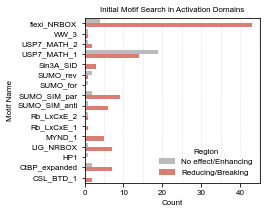

In [8]:
# make sure to first remove duplicates since there are overlapping tiles
mActRB2 = mActRB.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
mActRB2 = mActRB2[['Tile ID', 'Motif Name', 'Contains Reducing/Breaking Region?', 'Contains Motif?', 'Motif overlaps Reducing/Breaking Region?']]
mActRB2 = mActRB2.groupby(by=['Motif Name', 'Motif overlaps Reducing/Breaking Region?']).sum().reset_index()
mActRB2 = mActRB2.sort_values(by=['Motif Name', 'Motif overlaps Reducing/Breaking Region?'], ascending=[False, True])
mActRB2['Overlaps?'] = mActRB2['Motif overlaps Reducing/Breaking Region?'].replace([0, 1], ['No effect/Enhancing', 'Reducing/Breaking'])
mActRB2 = mActRB2[mActRB2['Motif Name']!='']
plt.figure(figsize=(3.75,3))
pal = sns.color_palette(['#BBBBBB', '#EA7063'])
sns.barplot(data=mActRB2, y='Motif Name', x='Contains Motif?', hue='Overlaps?', palette=pal)
plt.legend(frameon=False, title='Region', fontsize=8, loc='lower right', bbox_to_anchor=(1,0))

plt.xlabel('Count')
for i in range(0, 50, 5):
    plt.axvline(x=i, color='#BBBBBB', ls=':', lw=0.5, zorder=-1)
plt.title('Initial Motif Search in Activation Domains', fontsize=8)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S4/HHV_Activation-domains_reducing-breaking_initial-motif-search-summary.png', dpi=1200)


#### Results from search for motifs that overlap regions whose deletion breaks (i.e. completely abolishes) activation

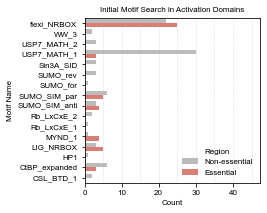

In [9]:
# make sure to first remove duplicates since there are overlapping tiles
mActB2 = mActB.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
mActB2 = mActB2[['Tile ID', 'Motif Name', 'Contains Breaking Region?', 'Contains Motif?', 'Motif overlaps Breaking Region?']]
mActB2 = mActB2.groupby(by=['Motif Name', 'Motif overlaps Breaking Region?']).sum().reset_index()
mActB2 = mActB2.sort_values(by=['Motif Name', 'Motif overlaps Breaking Region?'], ascending=[False, True])
mActB2['Overlaps?'] = mActB2['Motif overlaps Breaking Region?'].replace([0, 1], ['Non-essential', 'Essential'])
mActB2 = mActB2[mActB2['Motif Name']!='']
plt.figure(figsize=(3.75,3))
pal = sns.color_palette(['#BBBBBB', '#EA7063'])
sns.barplot(data=mActB2, y='Motif Name', x='Contains Motif?', hue='Overlaps?', palette=pal)
plt.legend(frameon=False, title='Region', fontsize=8, loc='lower right', bbox_to_anchor=(1,0))
plt.xlabel('Count')
for i in range(0, 50, 5):
    plt.axvline(x=i, color='#BBBBBB', ls=':', lw=0.5, zorder=-1)
plt.title('Initial Motif Search in Activation Domains', fontsize=8)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S4/HHV_Activation-domains_breaking_initial-motif-search-summary.png', dpi=1200)


Results from search for motifs that overlap regions whose deletion reduces or breaks (i.e. completely abolishes) repression

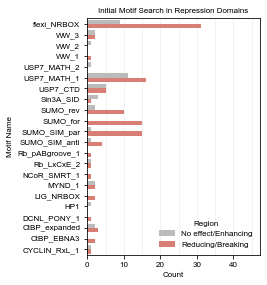

In [10]:
# make sure to first remove duplicates since there are overlapping tiles
mRepRB2 = mRepRB.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
mRepRB2 = mRepRB2[['Tile ID', 'Motif Name', 'Contains Reducing/Breaking Region?', 'Contains Motif?', 'Motif overlaps Reducing/Breaking Region?']]
mRepRB2 = mRepRB2[~mRepRB2['Tile ID'].isin(dual)]
mRepRB2 = mRepRB2.groupby(by=['Motif Name', 'Motif overlaps Reducing/Breaking Region?']).sum().reset_index()
mRepRB2 = mRepRB2.sort_values(by=['Motif Name', 'Motif overlaps Reducing/Breaking Region?'], ascending=[False, True])
mRepRB2['Overlaps?'] = mRepRB2['Motif overlaps Reducing/Breaking Region?'].replace([0, 1], ['No effect/Enhancing', 'Reducing/Breaking'])
mRepRB2 = mRepRB2[mRepRB2['Motif Name']!='']
plt.figure(figsize=(3.75,4))
pal = sns.color_palette(['#BBBBBB', '#EA7063'])
sns.barplot(data=mRepRB2, y='Motif Name', x='Contains Motif?', hue='Overlaps?', palette=pal)
plt.legend(frameon=False, title='Region', fontsize=8, loc='lower right', bbox_to_anchor=(1,0))
plt.xlabel('Count')
for i in range(0, 50, 5):
    plt.axvline(x=i, color='#BBBBBB', ls=':', lw=0.5, zorder=-1)
plt.title('Initial Motif Search in Repression Domains', fontsize=8)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S4/HHV_Repression-domains_reducing-breaking_initial-motif-search-summary.png', dpi=1200)


#### Results from search for motifs that overlap regions whose deletion breaks (i.e. completely abolishes) activation

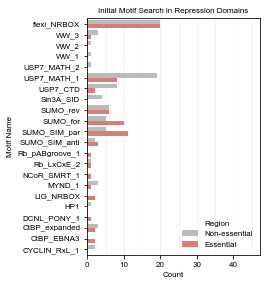

In [11]:
# make sure to first remove duplicates since there are overlapping tiles
mRepB2 = mRepB.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
mRepB2 = mRepB2[['Tile ID', 'Motif Name', 'Contains Breaking Region?', 'Contains Motif?', 'Motif overlaps Breaking Region?']]
mRepB2 = mRepB2[~mRepB2['Tile ID'].isin(dual)]
mRepB2 = mRepB2.groupby(by=['Motif Name', 'Motif overlaps Breaking Region?']).sum().reset_index()
mRepB2 = mRepB2.sort_values(by=['Motif Name', 'Motif overlaps Breaking Region?'], ascending=[False, True])
mRepB2['Overlaps?'] = mRepB2['Motif overlaps Breaking Region?'].replace([0, 1], ['Non-essential', 'Essential'])
mRepB2 = mRepB2[mRepB2['Motif Name']!='']
plt.figure(figsize=(3.75,4))
pal = sns.color_palette(['#BBBBBB', '#EA7063'])
sns.barplot(data=mRepB2, y='Motif Name', x='Contains Motif?', hue='Overlaps?', palette=pal)
plt.legend(frameon=False, title='Region', fontsize=8, loc='lower right', bbox_to_anchor=(1,0))
plt.xlabel('Count')
for i in range(0, 50, 5):
    plt.axvline(x=i, color='#BBBBBB', ls=':', lw=0.5, zorder=-1)
plt.title('Initial Motif Search in Repression Domains', fontsize=8)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S4/HHV_Repression-domains_breaking_initial-motif-search-summary.png', dpi=1200)


### Final motif search with new method - updated 2/2/2023

#### Define motifs for final search based on those that were relatively enriched in the above analysis

In [12]:
motifs2 = {'SUMO_SIM_anti':'[DEST]{1,10}.{0,1}[VIL][DESTVILMA][VIL][VILM].[DEST]{0,5}',
          'SUMO_SIM_par':'[DEST]{0,5}.[VILPTM][VIL][DESTVILMA][VIL].{0,1}[DEST]{1,10}',
          'SUMO_for':'[VILMAFP]K.E',
          'SUMO_rev':'[SDE].{0,5}[DE].K.{0,1}[AIFLMPSTV]',
          'HP1':'P[MVLIRWY]V[MVLIAS][LM]',
          'CtBP_expanded':'P.[DENS][LM].',
          'CtBP_EBNA3':'LDLS',
          'Sin3A_SID':'AA..L',
          'NCoR_SMRT_1':'P.K.R',
          'LIG_NRBOX':'[^P]L[^P][^P]LL[^P]',
          'flexi_NRBOX':'([^P][VIWF][^P][^P][VLIFY][VLIF][^P])|([^P][VLIWF][^P][^P][VIFY][VLIF][^P])|([^P][VLIWF][^P][^P][VLIFY][VIF][^P])',
          'MYND_1':'P.L.P',
          'CSL_BTD_1':'[AFILMPTVW]W[FHILMPSTVW]P',
          'WW_1':'PP.Y',
          'WW_2':'PPLP',
          'WW_3':'.PPR.'
         }

#### Quantify the number of domains that have an essential region and/or motif and whether these overlap. Barplots are featured in Fig. 3J.

Number of activation domains to analyze: 38
Category A: number of domains without any essential regions or motifs: 1
Category B: number of domains without any essential regions but with motifs: 9
Category C: number of domains with essential regions but no motifs: 3
Category D: number of domains with essential regions and motifs, but none of these overlap: 6
Category E: number of domains with a mix of essential regions with and without motifs: 16
Category F: number of domains where all essential regions have motifs: 3
Other: 0

            Motif  Activation
0            SUMO         NaN
1             SIM         9.0
2            CtBP         3.0
3            MYND         4.0
4  NR box (LxxLL)         5.0
5     flexiNR box        22.0
6           Other         NaN 



<ipython-input-13-2362530deafb>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EM111['Motif'] = EM111['Motif Name'].map(motifreplace)
<ipython-input-13-2362530deafb>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EM111['Motif'] = pd.Categorical(EM111['Motif'], categories=motif_cats, ordered=True)


Number of repression domains to analyze: 52
Category A: number of domains without any essential regions or motifs: 1
Category B: number of domains without any essential regions but with motifs: 4
Category C: number of domains with essential regions but no motifs: 3
Category D: number of domains with essential regions and motifs, but none of these overlap: 9
Category E: number of domains with a mix of essential regions with and without motifs: 23
Category F: number of domains where all essential regions have motifs: 12
Other: 0

            Motif  Repression
0            SUMO          16
1             SIM          14
2            CtBP           4
3            MYND           1
4  NR box (LxxLL)           2
5     flexiNR box          16
6           Other           2 



<ipython-input-13-2362530deafb>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EM111['Motif'] = EM111['Motif Name'].map(motifreplace)
<ipython-input-13-2362530deafb>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EM111['Motif'] = pd.Categorical(EM111['Motif'], categories=motif_cats, ordered=True)


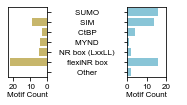

In [13]:
motif_cats = ['SUMO', 'SIM', 'CtBP', 'MYND', 'NR box (LxxLL)', 'flexiNR box', 'Other']

def quantify_motifs(df, effect):
    em000 = []
    em010 = []
    em100 = []
    em110_only = []
    em110_em111_mix = []
    em111_only = []
    other = []
    
    for t in list(set(list(df['Tile ID']))):
        tempdf = df[df['Tile ID']==t]
        ess = list(tempdf['Contains Breaking Region?'])
        mot = list(tempdf['Contains Motif?'])
        ovl = list(tempdf['Motif overlaps Breaking Region?'])
        
        if (1 not in ess) & (1 not in mot):
            em000.append(t)
        elif (1 not in ess) & (1 in mot):
            em010.append(t)
        elif (1 in ess) & (1 not in mot):
            em100.append(t)
        elif (1 in ess) & (1 in mot) & (1 not in ovl):
            em110_only.append(t)
        elif (1 in ess) & (1 in ovl) & (0 in ovl):
            em110_em111_mix.append(t)
        elif (0 not in ovl):
            em111_only.append(t)
        else:
            other.append(t)
    
    print('Category A: number of domains without any essential regions or motifs: %d' % len(em000))
    print('Category B: number of domains without any essential regions but with motifs: %d' % len(em010))
    print('Category C: number of domains with essential regions but no motifs: %d' % len(em100))
    print('Category D: number of domains with essential regions and motifs, but none of these overlap: %d' % len(em110_only))
    print('Category E: number of domains with a mix of essential regions with and without motifs: %d' % len(em110_em111_mix))
    print('Category F: number of domains where all essential regions have motifs: %d' % len(em111_only))
    print('Other: %d\n' % len(other))
    
    motifreplace = {'CtBP_expanded':'CtBP', 'CtBP_EBNA3':'CtBP', 'SUMO_SIM_anti':'SIM', 'SUMO_SIM_par':'SIM',
                    'SUMO_for':'SUMO', 'SUMO_rev':'SUMO', 'MYND_1':'MYND', 'LIG_NRBOX':'NR box (LxxLL)', 'flexi_NRBOX':'flexiNR box',
                    'NCoR_SMRT_1':'Other', 'WW_3':'Other'}
    
    EM111 = df[(df['Contains Breaking Region?']==1) & (df['Contains Motif?']==1) & (df['Motif overlaps Breaking Region?']==1)]
    EM111['Motif'] = EM111['Motif Name'].map(motifreplace)
    EM111['Motif'] = pd.Categorical(EM111['Motif'], categories=motif_cats, ordered=True)
    
    EM111 = EM111[['Motif', 'Contains Motif?']].groupby(by='Motif').sum().reset_index().sort_values(by='Motif')
    EM111 = EM111.rename(columns={'Contains Motif?':effect})
    print(EM111, '\n')
    return EM111

# exclude the following because they are redundant (adjacent to max tile) or primarily repressors
mAct2 = overlapping_motifs(Act2, motifs2, 'Activation', ['breaking'])
excludeA = ['Q9J3N2_006', 'F5HIC6_025', 'F5HCV3_060', 'P36384_108', 'P03179_055', 'Q2HR71_028']
mAct3 = mAct2[~mAct2['Tile ID'].isin(excludeA)]
mAct3 = mAct3.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
listA = list(set(list(mAct3['Tile ID'])))
print('Number of activation domains to analyze: %d' % len(listA))
mAct3_plot = quantify_motifs(mAct3, 'Activation')

# exclude the following because they are redundant (adjacent to perturbed tile) or primarily activator
mRep2 = overlapping_motifs(Rep2, motifs2, 'Repression', ['breaking'])
excludeR = ['F5HIC6_027']
mRep3 = mRep2[~mRep2['Tile ID'].isin(excludeR)]
mRep3 = mRep3[~mRep3['Tile ID'].isin(dual)]
mRep3 = mRep3.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
listR = list(set(list(mRep3['Tile ID'])))
print('Number of repression domains to analyze: %d' % len(listR))
mRep3_plot = quantify_motifs(mRep3, 'Repression')

df_plot = pd.merge(mAct3_plot, mRep3_plot, on='Motif', how='outer')

colors = ['#D6BF5C', '#7CCCE4']
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5))
sns.barplot(data=df_plot, x='Activation', y='Motif', ax=ax[0], color=colors[0])
ax[0].invert_xaxis()
ax[0].set_xticks([0, 10, 20])
ax[0].set_xlabel('Motif Count', labelpad=1.5)# in Activation\nEssential Regions')
ax[0].set_ylabel('')
ax[0].yaxis.tick_right()
ax[0].set_yticklabels([])

sns.barplot(data=df_plot, x='Repression', y='Motif', ax=ax[1], color=colors[1])
ax[1].set_xticks([0, 10, 20])
ax[1].set_xlabel('Motif Count', labelpad=1.5) # in Repression\nEssential Regions')
ax[1].set_yticklabels([m + '                             ' for m in motif_cats], ha='center')
ax[1].set_ylabel('')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 3/HHV_effector_domain_motif_count_summary.png', dpi=1200)


#### Pie charts featured in Fig. 3J.

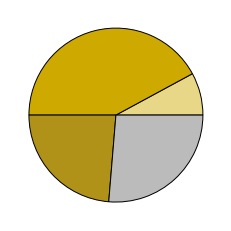

In [14]:
# [groupF, groupE, groupC + groupD, groupA + groupB]
plt.pie([3, 16, 9, 10], colors=['#E8D786', '#CEA900', '#AF9217', '#BBBBBB'],
        wedgeprops = {'edgecolor':'k', 'linewidth': 1})

plt.savefig('../Individual Figure Panels/Figure 3/HHV_Activation_motif_pie.png', dpi=1200)

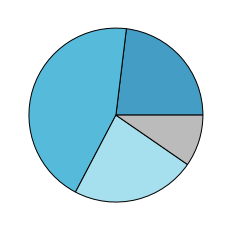

In [15]:
# [groupF, groupE, groupC + groupD, groupA + groupB]
# with dual included
# plt.pie([16, 26, 16, 5], colors=['#439DC4', '#56BBDA', '#A6DFEE', '#999999'],
#         wedgeprops = {'edgecolor':'k', 'linewidth': 1})

# with dual excluded
plt.pie([12, 23, 12, 5], colors=['#439DC4', '#56BBDA', '#A6DFEE', '#BBBBBB'],
        wedgeprops = {'edgecolor':'k', 'linewidth': 1})

plt.savefig('../Individual Figure Panels/Figure 3/HHV_Repression_motif_pie.png', dpi=1200)

#### Logos for intial flexiNR featured in Fig. S4M

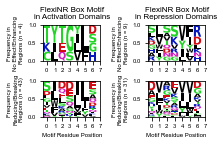

In [19]:
# !{sys.executable} -m pip install logomaker
import logomaker
font = {'family' : 'Arial',
        'size'   : 6}

matplotlib.rc('font', **font)

resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P', 'X'] #, 'X', '*', '-']

basemat = pd.DataFrame({aa:np.zeros(7) for aa in resorder})

def make_matrix(df, iterlist):
    for i in iterlist:
        for j, k in zip(list(i), range(7)):
            df.loc[k, j] += 1
    df = df.div(df.sum(axis=1), axis=0).drop(columns='X')
    return df

mActRB2 = mActRB.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
mRepRB2 = mRepRB.drop_duplicates(subset=['Virus', 'Protein', 'Motif Name', 'Motif Start', 'Motif End'])
mRepRB2 = mRepRB[~mRepRB['Tile ID'].isin(dual)]

Anelist = list(mActRB2[(mActRB2['Motif overlaps Reducing/Breaking Region?']==0) & (mActRB2['Motif Name']=='flexi_NRBOX')]['Motif Sequence'])
Arblist = list(mActRB2[(mActRB2['Motif overlaps Reducing/Breaking Region?']==1) & (mActRB2['Motif Name']=='flexi_NRBOX')]['Motif Sequence'])
Rnelist = list(mRepRB2[(mRepRB2['Motif overlaps Reducing/Breaking Region?']==0) & (mRepRB2['Motif Name']=='flexi_NRBOX')]['Motif Sequence'])
Rrblist = list(mRepRB2[(mRepRB2['Motif overlaps Reducing/Breaking Region?']==1) & (mRepRB2['Motif Name']=='flexi_NRBOX')]['Motif Sequence'])

### VERY IMPORTANT - MUST MAKE A NEW BASE MATRIX RIGHT BEFORE CALLING FUNCTION OR ELSE PREVIOUS MATRIX BECOMES BASE
### ^^^ NOT SURE WHY THIS HAPPENS OTHERWISE
basemat_Ane = pd.DataFrame({aa:np.zeros(7) for aa in resorder})
Ane_mat = make_matrix(basemat_Ane, Anelist)

basemat_Arb = pd.DataFrame({aa:np.zeros(7) for aa in resorder})
Arb_mat = make_matrix(basemat_Arb, Arblist)

basemat_Rne = pd.DataFrame({aa:np.zeros(7) for aa in resorder})
Rne_mat = make_matrix(basemat_Rne, Rnelist)

basemat_Rrb = pd.DataFrame({aa:np.zeros(7) for aa in resorder})
Rrb_mat = make_matrix(basemat_Rrb, Rrblist)

fig, ax = plt.subplots(2, 2, figsize=(3,2))
logomaker.Logo(Ane_mat, ax=ax[0, 0])
logomaker.Logo(Arb_mat, ax=ax[1, 0])
ax[0, 0].set_ylabel('Frequency in\nNo Effect/Enhancing\nRegions (n = %d)' % len(Anelist), fontsize=6)
ax[1, 0].set_xlabel('Motif Residue Position')
ax[1, 0].set_ylabel('Frequency in\nReducing/Breaking\nRegions (n = %d)' % len(Arblist), fontsize=6)
ax[0, 0].set_title('FlexiNR Box Motif\nin Activation Domains', fontsize=8)

logomaker.Logo(Rne_mat, ax=ax[0, 1])
logomaker.Logo(Rrb_mat, ax=ax[1, 1])
ax[0, 1].set_ylabel('Frequency in\nNo Effect/Enhancing\nRegions (n = %d)' % len(Rnelist), fontsize=6)
ax[1, 1].set_xlabel('Motif Residue Position')
ax[1, 1].set_ylabel('Frequency in\nReducing/Breaking\nRegions (n = %d)' % len(Rrblist), fontsize=6)
ax[0, 1].set_title('FlexiNR Box Motif\nin Repression Domains', fontsize=8)

for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_xticks(range(0,8))

# for a in ax.flatten():
#     a.set_xticks(range(7))
#     a.set_xticklabels(labels=a.get_xticklabels(), fontsize=6)
#     a.set_yticklabels(labels=a.get_yticklabels(), fontsize=6)

plt.tight_layout()

plt.savefig('../Individual Figure Panels/Figure S4/HHV_effector_domains_initial_flexiNRBOX_search_skinny.png', dpi=1200)



#### Logos for final flexiNR featured in Fig. 3J

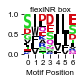

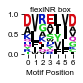

In [20]:
import logomaker
font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

Ablist = list(mAct3[(mAct3['Motif overlaps Breaking Region?']==1) & (mAct3['Motif Name']=='flexi_NRBOX')]['Motif Sequence'])
Rblist = list(mRep3[(mRep3['Motif overlaps Breaking Region?']==1) & (mRep3['Motif Name']=='flexi_NRBOX')]['Motif Sequence'])

basemat = pd.DataFrame({aa:np.zeros(7) for aa in resorder})
Ab_mat = make_matrix(basemat, Ablist)
basemat = pd.DataFrame({aa:np.zeros(7) for aa in resorder})
Rb_mat = make_matrix(basemat, Rblist)

def plot_logo(matrix, effect, nummotifs):
    fig, ax = plt.subplots(figsize=(1.2, 1.2))
    logomaker.Logo(matrix, ax=ax)
    ax.set_title('flexiNR box', fontsize=8, pad=2)# (n = %d)' % nummotifs, pad=2, fontsize=8) #flexi NR Box Motif in Activation Domains', fontsize=8)
    ax.set_xlabel('Motif Position')
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.tick_params(axis='x', pad=2)
    ax.set_ylabel('') #'Frequency in\nNo Effect/Enhancing\nRegions (n = %d)' % len(Anelist))#, fontsize=6)
    ax.set_yticks([0, 0.5, 1])
    ax.tick_params(axis='y', pad=2)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure 3/HHV_%s_domains_essential-regions_flexiNRBOX_search.png' % effect, dpi=1200)
    
plot_logo(Ab_mat, 'Activation', len(Ablist))
plot_logo(Rb_mat, 'Repression', len(Rblist))

### Chemical inhibition

#### Screen analysis for all chemical inhibition screens

In [24]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from statistics import geometric_mean

# do once to create file
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

# from primary screen
orig_cutoffA = 1.0846347878236864
orig_cutoffR = 0.6987727639587653

# filter out library members with too few reads, add meta data about perturbation type, and calculate hits threshold
# screen_type should be 'Act' or 'Rep'
def process_screen(df, screen_type, condition, sigma, counts_filter):
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    df = df[(df['countsSUM_R1']>=counts_filter) & (df['countsSUM_R2']>=counts_filter)]
    
    if screen_type == 'Act':
        df['R1'] = -df['R1']
        df['R2'] = -df['R2']
        df['Avg'] = -df['Avg']
        
    rand = list(df[(df['Oligo ID'].str.contains('random')) & (df['Effect']=='-')]['Avg'])
    thresh = np.mean(rand) + sigma*np.std(rand)
    df['Hit'] = np.where(df['Avg']>=thresh, 1, 0)
    df['Condition'] = screen_type + '_' + condition
    
    print('%s screen:' % (screen_type + '_' + condition))
    print('\tElements passing summed counts filter of %d: %d' % (counts_filter, len(df)))
    print('\tHits threshold with %d*sigma: %s' % (sigma, str(thresh)))
    
    return df, thresh

# add additional information, including fiducial details, WT tile effect, and other meta data
# IMPORTANT: all mutations are off by +1, so this code corrects for that
def add_info(df, fiducials, prot_seqs, condition):
    # merge in fiducial information and protein sequences
    df = df.rename(columns={'label':'Oligo ID'})
    df['Oligo ID'] = np.where(df['Oligo ID'].str.contains('random_'), 'HHV-Hits_random-' + df['Oligo ID'].str.split('_').str[2:].str.join('_'), df['Oligo ID'])
    df['Tile ID'] = df['Oligo ID'].str.split('_').str[1:].str.join('_')

    df = pd.merge(df, fiducials[['Tile ID', 'Gene', 'Effect']], on=['Tile ID'], how='left')
    df = pd.merge(df, prot_seqs.rename(columns={'Name':'Tile ID'}), on=['Oligo ID', 'Tile ID'], how='left')
    df['Protein'] = np.where(df['Type']=='fiducial control', df['Gene'], df['Protein'])
    
    df['Effect'] = np.where(df['Activation']>=orig_cutoffA, 'activator', df['Effect'])
    df['Effect'] = np.where(df['Repression']>=orig_cutoffR, 'repressor', df['Effect'])
    df['Effect'] = np.where((df['Activation']>=orig_cutoffA) & (df['Repression']>=orig_cutoffR), 'dual', df['Effect'])
    df['Effect'] = np.where(df['Effect'].isnull(), '-', df['Effect'])
    df = df.drop(columns=['Gene'])
    
    return df

fiducials = pd.read_csv('../Supplemental Tables - CSV/fiducial_controls.csv', sep=',').drop(columns='Unnamed: 0')
fiducials['Number'] = fiducials.index + 1
fiducials['Tile ID'] = 'fiducial_' + fiducials['Number'].astype(str).str.zfill(3)
fiducials['Effect'] = np.where(fiducials['Description'].str.contains('Repr'), 'repressor', 'activator')
fiducials['Effect'] = np.where(fiducials['label'].str.contains('random'), '-', fiducials['Effect'])

prot_seqs = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_added-info.csv')

# read in necessary files as dataframes: screen scores, fiducials, and details on original WT max tiles
Act_DMSO = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act_DMSO_combo.csv', sep=',')
Act_DMSO = add_info(Act_DMSO, fiducials, prot_seqs, 'Act_DMSO')
Act_DMSO, threshA_DMSO = process_screen(Act_DMSO, 'Act', 'DMSO', 2, 50)
Act_DMSO.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act_DMSO_combo_expanded.csv', index=False)

Act_SGC = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act_SGC-CBP30_combo.csv', sep=',')
Act_SGC = add_info(Act_SGC, fiducials, prot_seqs, 'Act_SGC-CBP30')
Act_SGC, threshA_SGC = process_screen(Act_SGC, 'Act', 'SGC-CBP30', 2, 50)
Act_SGC.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act_SGC-CBP30_combo_expanded.csv', index=False)

Rep_DMSO = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Rep_DMSO_combo.csv', sep=',')
Rep_DMSO = add_info(Rep_DMSO, fiducials, prot_seqs, 'Rep_DMSO')
Rep_DMSO, threshR_DMSO = process_screen(Rep_DMSO, 'Rep', 'DMSO', 2, 50)
Rep_DMSO.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Rep_DMSO_combo_expanded.csv', index=False)

Rep_taz = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Rep_taz_combo.csv', sep=',')
Rep_taz = add_info(Rep_taz, fiducials, prot_seqs, 'Rep_taz')
Rep_taz, threshR_taz = process_screen(Rep_taz, 'Rep', 'taz', 2, 50)
Rep_taz.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Rep_taz_combo_expanded.csv', index=False)

Rep_TMP = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Rep_TMP269_combo.csv', sep=',')
Rep_TMP = add_info(Rep_TMP, fiducials, prot_seqs, 'Rep_TMP269')
Rep_TMP, threshR_TMP = process_screen(Rep_TMP, 'Rep', 'TMP269', 2, 50)
Rep_TMP.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Rep_TMP269_combo_expanded.csv', index=False)

Act_D1_DMSO = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act-D1_DMSO_combo.csv', sep=',')
Act_D1_DMSO = add_info(Act_D1_DMSO, fiducials, prot_seqs, 'Act_D1_DMSO')
Act_D1_DMSO, threshA_D1_DMSO = process_screen(Act_D1_DMSO, 'Act', 'D1_DMSO', 2, 50)
Act_D1_DMSO.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act-D1_DMSO_combo_expanded.csv', index=False)

Act_celastrol = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act-D1_celastrol_combo.csv', sep=',')
Act_celastrol = add_info(Act_celastrol, fiducials, prot_seqs, 'Act_D1_celastrol')
Act_celastrol, threshA_celastrol = process_screen(Act_celastrol, 'Act', 'D1_celastrol', 2, 50)
Act_celastrol.to_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_Act-D1_celastrol_combo_expanded.csv', index=False)


<ipython-input-24-ebc7585bb824>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R1'] = -df['R1']
<ipython-input-24-ebc7585bb824>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R2'] = -df['R2']
<ipython-input-24-ebc7585bb824>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Act_DMSO screen:
	Elements passing summed counts filter of 50: 1004
	Hits threshold with 2*sigma: -0.579627122236684
Act_SGC-CBP30 screen:
	Elements passing summed counts filter of 50: 1002
	Hits threshold with 2*sigma: -0.49891899387213723
Rep_DMSO screen:
	Elements passing summed counts filter of 50: 996
	Hits threshold with 2*sigma: -0.17959803772519833
Rep_taz screen:
	Elements passing summed counts filter of 50: 978
	Hits threshold with 2*sigma: -0.031428002052666826
Rep_TMP269 screen:
	Elements passing summed counts filter of 50: 1001
	Hits threshold with 2*sigma: -0.15469759287329354
Act_D1_DMSO screen:
	Elements passing summed counts filter of 50: 1016
	Hits threshold with 2*sigma: -0.3508205030420707
Act_D1_celastrol screen:
	Elements passing summed counts filter of 50: 1016
	Hits threshold with 2*sigma: 0.0052234349579478034


<ipython-input-24-ebc7585bb824>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R1'] = -df['R1']
<ipython-input-24-ebc7585bb824>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R2'] = -df['R2']
<ipython-input-24-ebc7585bb824>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

#### Reproducibility plots for all chemical inhibition screens not featured in a figure panel.

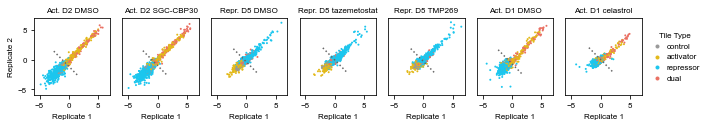

In [34]:
fig, ax = plt.subplots(1, 7, figsize=(10,1.8))
dfList = [Act_DMSO, Act_SGC, Rep_DMSO, Rep_taz, Rep_TMP, Act_D1_DMSO, Act_celastrol]
titleList = ['Act. D2 DMSO', 'Act. D2 SGC-CBP30', 'Repr. D5 DMSO', 'Repr. D5 tazemetostat', 'Repr. D5 TMP269', 'Act. D1 DMSO', 'Act. D1 celastrol']
threshList = [threshA_DMSO, threshA_SGC, threshR_DMSO, threshR_taz, threshR_TMP, threshA_D1_DMSO, threshA_celastrol]
axrange = range(7)
colors = ['#999999', '#E3B919', '#1BC6EE', '#EA7063']

for d, l, t, i in zip(dfList, titleList, threshList, axrange):
    d['Effect'] = np.where(d['Effect']=='-', 'control', d['Effect'])
    d['Effect'] = pd.Categorical(d['Effect'], categories=['control', 'activator', 'repressor', 'dual'])

    sns.scatterplot(data=d, x='R1', y='R2', ax=ax[i], linewidth=0, hue='Effect', s=4, palette=colors) #, style='Type')
    ax[i].set_xlabel('Replicate 1')
    ax[i].set_xlim(-6, 7)
    ax[i].set_ylim(-6, 7)
    if i == 0:
        ax[i].set_ylabel('Replicate 2')
    else:
        ax[i].set_ylabel('')
        ax[i].set_yticks([])
        
    ax[i].plot([t-2, t+2], [t+2, t-2], ls=':', color='#666666')
    ax[i].set_title(l, fontsize=8)
    if i == 6:
        ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Tile Type',
                     markerscale=0.5, handletextpad=0.2)
    else:
        ax[i].legend('', frameon=False)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S4/HHVhits_chem-inhib_reproducibility_scatter.png', dpi=1200)

#### p300/CBP KIX inhibition with celastrol - plot tiles from top 20 most sensitive proteins as featured in Fig. 3K

183
Number of hit tiles sensitive to inhibition: 148
Number of hit tiles sensitive to inhibition with NR or flexiNR box: 89
Number of hit tiles not sensitive to inhibition: 35
Number of hit tiles not sensitive to inhibition with NR or flexiNR box: 23
Number of proteins with hit tiles sensitive to inhibition: 51


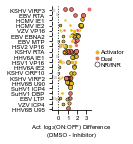

In [49]:
import random
from matplotlib.lines import Line2D

AD1_DMSO_avg = Act_D1_DMSO[['Tile ID', 'Protein', 'Protein Sequence', 'Avg', 'Effect', 'Type', 'Virus Abbreviation']].rename(columns={'Avg':'DMSO'})
A_celastrol_avg = Act_celastrol[['Tile ID', 'Avg']].rename(columns={'Avg':'celastrol'})
plot_df = pd.merge(AD1_DMSO_avg, A_celastrol_avg, on='Tile ID', how='inner')
plot_df = plot_df.replace({'vIRF3':'VIRF3'})
plot_df['UniProt ID'] = plot_df['Tile ID'].str.split('_').str[0]
plot_df['Diff'] = plot_df['DMSO'] - plot_df['celastrol']
plot_df['anyNR'] = np.where(plot_df['Protein Sequence'].str.contains('[^P][VLIWF][^P][^P][VLIFY][VLIF][^P]'), 1, 0)

plot_df = plot_df[plot_df['Effect']!='-']
plot_df = plot_df[plot_df['Type']=='HHV tile']
eff_scores = list(plot_df[plot_df['Effect'].str.contains('repressor')]['Diff'])
eff_mean = np.mean(eff_scores)
eff_std = np.std(eff_scores)
upperlimcelastrol = eff_mean + 2*eff_std
lowerlim = eff_mean - 2*eff_std

print(len(plot_df[plot_df['DMSO']>=threshA_D1_DMSO]))
print('Number of hit tiles sensitive to inhibition:', len(plot_df[(plot_df['Diff']>=upperlimcelastrol) & (plot_df['DMSO']>=threshA_D1_DMSO)]))
print('Number of hit tiles sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']>=upperlimcelastrol) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshA_D1_DMSO)]))
print('Number of hit tiles not sensitive to inhibition:', len(plot_df[(plot_df['Diff']<upperlimcelastrol) & (plot_df['DMSO']>=threshA_D1_DMSO)]))
print('Number of hit tiles not sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']<upperlimcelastrol) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshA_D1_DMSO)]))

# print('Number of hit tiles sensitive to inhibition:', len(plot_df[plot_df['Diff']>upperlimcelastrol]))
# dfA_celastrol = plot_df[plot_df['DMSO']>threshA_DMSO]

# plot_df = plot_df[plot_df['Effect']!='repressor']
plot_df = plot_df[plot_df['DMSO']>threshA_DMSO]
plot_df['Effect'] = pd.Categorical(plot_df['Effect'], categories=['activator', 'repressor', 'dual'], ordered=True)
plot_df = plot_df[plot_df['Effect']!='repressor']

tokeep = list(set(list(plot_df[plot_df['Diff']>upperlimcelastrol]['UniProt ID'])))
plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep)]
plot_df = plot_df.sort_values(by=['Diff'], ascending=False).reset_index(drop=True)
plot_df['ID'] = plot_df['Protein'] + ' ' + plot_df['UniProt ID']
plot_df['ID2'] = plot_df['Virus Abbreviation'] + ' ' + plot_df['Protein']

tokeep2 = plot_df[['UniProt ID', 'Diff']].groupby('UniProt ID', sort=False).sum().reset_index().drop_duplicates(subset='UniProt ID')
print('Number of proteins with hit tiles sensitive to inhibition:', len(tokeep2))
tokeep2 = list(tokeep2['UniProt ID'])[:22]

plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep2)]

tile = list(plot_df['Tile ID'])
xpos = list(plot_df['Diff'])
ypos = list(plot_df['ID2'])
size = list(plot_df['DMSO'])
size = [((s+min(size))/(max(size)+min(size))+1.5)*2 for s in size]
effect = list(plot_df['Effect'])
anyNR = list(plot_df['anyNR'])

colorDict = {'activator':'#E3B919', 'dual':'#EA7063'}
tiles = ['P06492_041', 'P03209_052', 'Q2HRC9_015', 'Q2HR71_017', 'F5HCV3_054', 'Q2HRD3_107']

plt.figure(figsize=(1.4, 2.05))
y2i = {}
i2y = {}
i = 0
for t, x, y, s, e, a in zip(tile, xpos, ypos, size, effect, anyNR):
    if a == 1:
        edgecolor = 'black'
#     if t in tiles:
#         edgecolor = 'black'
        zorder=5
    else:
        edgecolor = 'white'
        zorder=0
    if y not in y2i:
        y2i[y] = i
        i2y[i] = y
        plt.plot(x, i+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5, zorder=zorder)
        i += 1
    else:
        plt.plot(x, y2i[y]+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5)

plt.yticks(ticks=range(len(y2i)), labels=list(y2i.keys()))
plt.gca().invert_yaxis()

plt.axvspan(xmin=-0.8, xmax=upperlimcelastrol,
            ymin=plt.gca().get_ylim()[1]+0.5,
            ymax=plt.gca().get_ylim()[0],
            color='white', alpha=0.75, zorder=10)
# plt.ylim(plt.gca().get_ylim()[0]-0.5, plt.gca().get_ylim()[1]+0.5)
plt.yticks(fontsize=6)
plt.xlim(eff_mean, plt.gca().get_xlim()[1])
plt.ylim(plt.gca().get_ylim()[0]-0.5, plt.gca().get_ylim()[1]+0.5)
plt.xticks([0, 1, 2, 3], fontsize=6)
plt.gca().tick_params(axis='x', pad=1.5)
plt.axvline(x=eff_mean, color='#333333', ls='--', lw=1, zorder=15)
# plt.axvline(x=lowerlim, color='#333333', ls=':', lw=1, zorder=15)
plt.axvline(x=upperlimcelastrol, color='#333333', ls=':', lw=1, zorder=15)
plt.xlabel('Act. log$_2$(ON:OFF) Difference\n(DMSO - Inhibitor)', fontsize=6, labelpad=0.5)
# plt.title('p300/CBP Inhibition', fontsize=8, pad=2.5)
sns.despine()

legend_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label='Activator',
                          markerfacecolor=colorDict['activator'], markersize=5),
                   Line2D([0], [0], marker='o', color='#FFFFFF', label='Dual',
                          markerfacecolor=colorDict['dual'], markersize=5),
                   Line2D([0], [0], marker='o', color='k', label='NR/fNR',
                          markerfacecolor='white', markersize=5, mew=0.5)]
#                    Line2D([0], [0], marker='o', color='k', label='Validated',
#                           markerfacecolor='white', markersize=5, mew=0.5)]

plt.tight_layout()
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
           frameon=False, ncol=1, handlelength=0.2, handletextpad=0.5, labelspacing=0.2, fontsize=6)

plt.savefig('../Individual Figure Panels/Figure 3/HHV_Activation_difference_p300-CBP_KIX_inhibition_vs_DMSO.png', dpi=1200, bbox_inches='tight')

#### p300/CBP inhibition with SGC-CBP30 - plot tiles from top 10 most sensitive proteins as featured in Fig. 3K

245
Number of hit tiles sensitive to inhibition: 18
Number of hit tiles sensitive to inhibition with NR or flexiNR box: 7
Number of hit tiles not sensitive to inhibition: 227
Number of hit tiles not sensitive to inhibition with NR or flexiNR box: 137
Number of proteins with hit tiles sensitive to inhibition: 14


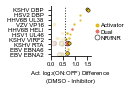

In [54]:
import random
from matplotlib.lines import Line2D

A_DMSO_avg = Act_DMSO[['Tile ID', 'Protein', 'Protein Sequence', 'Avg', 'Effect', 'Type', 'Virus Abbreviation']].rename(columns={'Avg':'DMSO'})
A_SGC_avg = Act_SGC[['Tile ID', 'Avg']].rename(columns={'Avg':'SGC-CBP30'})
plot_df = pd.merge(A_DMSO_avg, A_SGC_avg, on='Tile ID', how='inner')
plot_df['UniProt ID'] = plot_df['Tile ID'].str.split('_').str[0]
plot_df['Diff'] = plot_df['DMSO'] - plot_df['SGC-CBP30']
plot_df['anyNR'] = np.where(plot_df['Protein Sequence'].str.contains('[^P][VLIWF][^P][^P][VLIFY][VLIF][^P]'), 1, 0)

plot_df = plot_df[plot_df['Effect']!='-']
plot_df = plot_df[plot_df['Type']=='HHV tile']
eff_scores = list(plot_df[plot_df['Effect'].str.contains('repressor')]['Diff'])
eff_mean = np.mean(eff_scores)
eff_std = np.std(eff_scores)
upperlimSGC = eff_mean + 2*eff_std
lowerlim = eff_mean - 2*eff_std

print(len(plot_df[plot_df['DMSO']>=threshA_DMSO]))
print('Number of hit tiles sensitive to inhibition:', len(plot_df[(plot_df['Diff']>=upperlimSGC) & (plot_df['DMSO']>=threshA_DMSO)]))
print('Number of hit tiles sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']>=upperlimSGC) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshA_DMSO)]))
print('Number of hit tiles not sensitive to inhibition:', len(plot_df[(plot_df['Diff']<upperlimSGC) & (plot_df['DMSO']>=threshA_DMSO)]))
print('Number of hit tiles not sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']<upperlimSGC) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshA_DMSO)]))

# print('Number of hit tiles sensitive to inhibition:', len(plot_df[plot_df['Diff']>upperlimSGC]))
# dfA_SGC = plot_df[plot_df['DMSO']>threshA_DMSO]

# plot_df = plot_df[plot_df['Effect']!='repressor']
plot_df = plot_df[plot_df['DMSO']>threshA_DMSO]
plot_df['Effect'] = pd.Categorical(plot_df['Effect'], categories=['activator', 'repressor', 'dual'], ordered=True)

tokeep = list(set(list(plot_df[plot_df['Diff']>upperlimSGC]['UniProt ID'])))
plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep)]
plot_df = plot_df.sort_values(by=['Diff'], ascending=False).reset_index(drop=True)
plot_df['ID'] = plot_df['Protein'] + ' ' + plot_df['UniProt ID']
plot_df['ID2'] = plot_df['Virus Abbreviation'] + ' ' + plot_df['Protein']

tokeep2 = plot_df[['UniProt ID', 'Diff']].groupby('UniProt ID', sort=False).sum().reset_index().drop_duplicates(subset='UniProt ID')
print('Number of proteins with hit tiles sensitive to inhibition:', len(tokeep2))
tokeep2 = list(tokeep2['UniProt ID'])[:10]

plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep2)]

tile = list(plot_df['Tile ID'])
xpos = list(plot_df['Diff'])
ypos = list(plot_df['ID2'])
size = list(plot_df['DMSO'])
size = [((s+min(size))/(max(size)+min(size))+1.5)*2 for s in size]
effect = list(plot_df['Effect'])
anyNR = list(plot_df['anyNR'])

colorDict = {'activator':'#E3B919', 'dual':'#EA7063'}
tiles = ['P06492_041', 'P03209_052', 'Q2HRC9_015', 'Q2HR71_017', 'F5HCV3_054', 'Q2HRD3_107']

plt.figure(figsize=(1.4, 1.3))
y2i = {}
i2y = {}
i = 0
for t, x, y, s, e, a in zip(tile, xpos, ypos, size, effect, anyNR):
    if a == 1:
        edgecolor = 'black'
#     if t in tiles:
#         edgecolor = 'black'
        zorder=5
    else:
        edgecolor = 'white'
        zorder=0
    if y not in y2i:
        y2i[y] = i
        i2y[i] = y
        plt.plot(x, i+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5, zorder=zorder)
        i += 1
    else:
        plt.plot(x, y2i[y]+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5)

plt.yticks(ticks=range(len(y2i)), labels=list(y2i.keys()))
plt.gca().invert_yaxis()

plt.axvspan(xmin=0.04, xmax=upperlimSGC,
            ymin=plt.gca().get_ylim()[1]+0.675,
            ymax=plt.gca().get_ylim()[0],
            color='white', alpha=0.75, zorder=10)
# plt.ylim(plt.gca().get_ylim()[0]-0.5, plt.gca().get_ylim()[1]+0.5)
plt.yticks(fontsize=6)
plt.xlim(eff_mean, plt.gca().get_xlim()[1])
plt.xticks([0, 0.5, 1, 1.5], fontsize=6)
plt.gca().tick_params(axis='x', pad=1.5)
plt.axvline(x=eff_mean, color='#333333', ls='--', lw=1, zorder=15)
# plt.axvline(x=lowerlim, color='#333333', ls=':', lw=1, zorder=15)
plt.axvline(x=upperlimSGC, color='#333333', ls=':', lw=1, zorder=15)
plt.xlabel('Act. log$_2$(ON:OFF) Difference\n(DMSO - Inhibitor)', fontsize=6, labelpad=0.5)
# plt.title('p300/CBP Inhibition', fontsize=8, pad=2.5)
sns.despine()

legend_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label='Activator',
                          markerfacecolor=colorDict['activator'], markersize=5),
                   Line2D([0], [0], marker='o', color='#FFFFFF', label='Dual',
                          markerfacecolor=colorDict['dual'], markersize=5),
                   Line2D([0], [0], marker='o', color='k', label='NR/fNR',
                          markerfacecolor='white', markersize=5, mew=0.5)]
#                    Line2D([0], [0], marker='o', color='k', label='Validated',
#                           markerfacecolor='white', markersize=5, mew=0.5)]

plt.tight_layout()
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
           frameon=False, ncol=1, handlelength=0.2, handletextpad=0.5, labelspacing=0.2, fontsize=6)

plt.savefig('../Individual Figure Panels/Figure 3/HHV_Activation_difference_p300-CBP_inhibition_vs_DMSO.png', dpi=1200, bbox_inches='tight')

#### EZH2 inhibition with tazemetostat - plot tiles from top 10 most sensitive proteins as featured in Fig. 3K

404
Number of hit tiles sensitive to inhibition: 27
Number of hit tiles sensitive to inhibition with NR or flexiNR box: 8
Number of hit tiles not sensitive to inhibition: 377
Number of hit tiles not sensitive to inhibition with NR or flexiNR box: 216
Number of proteins with hit tiles sensitive to inhibition: 20


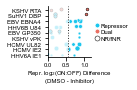

In [51]:
import random
from matplotlib.lines import Line2D

R_DMSO_avg = Rep_DMSO[['Tile ID', 'Protein', 'Protein Sequence', 'Avg', 'Effect', 'Type', 'Virus Abbreviation']].rename(columns={'Avg':'DMSO'})
R_taz_avg = Rep_taz[['Tile ID', 'Avg']].rename(columns={'Avg':'tazemetostat'})
plot_df = pd.merge(R_DMSO_avg, R_taz_avg, on='Tile ID', how='inner')
plot_df['UniProt ID'] = plot_df['Tile ID'].str.split('_').str[0]
plot_df['Diff'] = plot_df['DMSO'] - plot_df['tazemetostat']
plot_df['anyNR'] = np.where(plot_df['Protein Sequence'].str.contains('[^P][VLIWF][^P][^P][VLIFY][VLIF][^P]'), 1, 0)

plot_df = plot_df[plot_df['Effect']!='-']
plot_df = plot_df[plot_df['Type']=='HHV tile']
eff_scores = list(plot_df[plot_df['Effect'].str.contains('activator')]['Diff'])
eff_mean = np.mean(eff_scores)
eff_std = np.std(eff_scores)
upperlimtaz = eff_mean + 2*eff_std
lowerlim = eff_mean - 2*eff_std

print(len(plot_df[plot_df['DMSO']>=threshR_DMSO]))
print('Number of hit tiles sensitive to inhibition:', len(plot_df[(plot_df['Diff']>=upperlimtaz) & (plot_df['DMSO']>=threshR_DMSO)]))
print('Number of hit tiles sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']>=upperlimtaz) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshR_DMSO)]))
print('Number of hit tiles not sensitive to inhibition:', len(plot_df[(plot_df['Diff']<upperlimtaz) & (plot_df['DMSO']>=threshR_DMSO)]))
print('Number of hit tiles not sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']<upperlimtaz) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshR_DMSO)]))


# print('Number of hit tiles sensitive to inhibition:', len(plot_df[plot_df['Diff']>upperlimtaz]))
# # dfR_taz = plot_df[plot_df['Diff']>upperlimtaz]
# dfR_taz = plot_df[plot_df['DMSO']>threshR_DMSO]

# plot_df = plot_df[plot_df['Effect']!='repressor']
plot_df = plot_df[plot_df['DMSO']>threshR_DMSO]
plot_df['Effect'] = pd.Categorical(plot_df['Effect'], categories=['activator', 'repressor', 'dual'], ordered=True)

tokeep = list(set(list(plot_df[plot_df['Diff']>upperlimtaz]['UniProt ID'])))
plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep)]
plot_df = plot_df.sort_values(by=['Diff'], ascending=False)
plot_df['ID'] = plot_df['Protein'] + ' ' + plot_df['UniProt ID']
plot_df['ID2'] = plot_df['Virus Abbreviation'] + ' ' + plot_df['Protein']

tokeep2 = plot_df[['UniProt ID', 'Diff']].groupby('UniProt ID', sort=False).sum().reset_index().drop_duplicates(subset='UniProt ID')
print('Number of proteins with hit tiles sensitive to inhibition:', len(tokeep2))
tokeep2 = list(tokeep2['UniProt ID'])[:10]

plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep2)]

tile = list(plot_df['Tile ID'])
xpos = list(plot_df['Diff'])
ypos = list(plot_df['ID2'])
size = list(plot_df['DMSO'])
size = [((s+min(size))/(max(size)+min(size))+1.5)*2 for s in size]
effect = list(plot_df['Effect'])
anyNR = list(plot_df['anyNR'])

colorDict = {'activator':'#E3B919', 'dual':'#EA7063', 'repressor':'#1BC6EE'}
# tiles = ['P06492_041', 'P03209_052', 'Q2HRC9_015', 'Q2HR71_017', 'F5HCV3_054', 'Q2HRD3_107']

plt.figure(figsize=(1.4, 1.3))
y2i = {}
i2y = {}
i = 0
for t, x, y, s, e, a in zip(tile, xpos, ypos, size, effect, anyNR):
    if a == 1:
        edgecolor = 'black'
#     if t in tiles:
#         edgecolor = 'black'
        zorder=5
    else:
        edgecolor = 'white'
        zorder=0
    if y not in y2i:
        y2i[y] = i
        i2y[i] = y
        plt.plot(x, i+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5, zorder=zorder)
        i += 1
    else:
        plt.plot(x, y2i[y]+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5)

plt.yticks(ticks=range(len(y2i)), labels=list(y2i.keys()))
plt.gca().invert_yaxis()

plt.axvspan(xmin=0.025, xmax=upperlimtaz,
            ymin=plt.gca().get_ylim()[1]+0.63,
            ymax=plt.gca().get_ylim()[0],
            color='white', alpha=0.75, zorder=10)
# plt.ylim(plt.gca().get_ylim()[0]-0.5, plt.gca().get_ylim()[1]+0.5)
plt.yticks(fontsize=6)
plt.xlim(eff_mean, plt.gca().get_xlim()[1])
plt.xticks([0, 0.5, 1], fontsize=6)
plt.gca().tick_params(axis='x', pad=1.5)
# plt.axvline(x=eff_mean, color='#333333', ls='--', lw=1, zorder=15)
# plt.axvline(x=lowerlim, color='#333333', ls=':', lw=1, zorder=15)
plt.axvline(x=upperlimtaz, color='#333333', ls=':', lw=1, zorder=15)
plt.xlabel('Repr. log$_2$(ON:OFF) Difference\n(DMSO - Inhibitor)', fontsize=6, labelpad=0.5)
# plt.title('EZH2 Inhibition', fontsize=8, pad=2.5)
sns.despine()

legend_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label='Repressor',
                          markerfacecolor=colorDict['repressor'], markersize=5),
                   Line2D([0], [0], marker='o', color='#FFFFFF', label='Dual',
                          markerfacecolor=colorDict['dual'], markersize=5),
                   Line2D([0], [0], marker='o', color='k', label='NR/fNR',
                          markerfacecolor='white', markersize=5, mew=0.5)]
#                    Line2D([0], [0], marker='o', color='k', label='Validated',
#                           markerfacecolor='white', markersize=5, mew=0.5)]

plt.tight_layout()
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
           frameon=False, ncol=1, handlelength=0.2, handletextpad=0.5, labelspacing=0.2, fontsize=6)

plt.savefig('../Individual Figure Panels/Figure 3/HHV_Activation_difference_EZH2_inhibition_vs_DMSO.png', dpi=1200, bbox_inches='tight')

#### Class IIa HDAC inhibition with TMP269 - plot tiles from top 10 most sensitive proteins as featured in Fig. 3K

409
Number of hit tiles sensitive to inhibition: 129
Number of hit tiles sensitive to inhibition with NR or flexiNR box: 82
Number of hit tiles not sensitive to inhibition: 280
Number of hit tiles not sensitive to inhibition with NR or flexiNR box: 147
Number of proteins with hit tiles sensitive to inhibition: 83


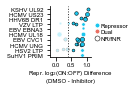

In [52]:
import random
from matplotlib.lines import Line2D

R_DMSO_avg = Rep_DMSO[['Tile ID', 'Protein', 'Protein Sequence', 'Avg', 'Effect', 'Type', 'Virus Abbreviation']].rename(columns={'Avg':'DMSO'})
R_TMP_avg = Rep_TMP[['Tile ID', 'Avg']].rename(columns={'Avg':'TMP269'})
plot_df = pd.merge(R_DMSO_avg, R_TMP_avg, on='Tile ID', how='inner')
plot_df['UniProt ID'] = plot_df['Tile ID'].str.split('_').str[0]
plot_df['Diff'] = plot_df['DMSO'] - plot_df['TMP269']
plot_df['anyNR'] = np.where(plot_df['Protein Sequence'].str.contains('[^P][VLIWF][^P][^P][VLIFY][VLIF][^P]'), 1, 0)

plot_df = plot_df[plot_df['Effect']!='-']
plot_df = plot_df[plot_df['Type']=='HHV tile']
eff_scores = list(plot_df[plot_df['Effect'].str.contains('activator')]['Diff'])
eff_mean = np.mean(eff_scores)
eff_std = np.std(eff_scores)
upperlimTMP = eff_mean + 2*eff_std
lowerlim = eff_mean - 2*eff_std

print(len(plot_df[plot_df['DMSO']>=threshR_DMSO]))
print('Number of hit tiles sensitive to inhibition:', len(plot_df[(plot_df['Diff']>=upperlimTMP) & (plot_df['DMSO']>=threshR_DMSO)]))
print('Number of hit tiles sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']>=upperlimTMP) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshR_DMSO)]))
print('Number of hit tiles not sensitive to inhibition:', len(plot_df[(plot_df['Diff']<upperlimTMP) & (plot_df['DMSO']>=threshR_DMSO)]))
print('Number of hit tiles not sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']<upperlimTMP) & (plot_df['anyNR']==1) & (plot_df['DMSO']>=threshR_DMSO)]))

# print('Number of hit tiles sensitive to inhibition:', len(plot_df[plot_df['Diff']>upperlimTMP]))
# print('Number of hit tiles sensitive to inhibition with NR or flexiNR box:', len(plot_df[(plot_df['Diff']>upperlimTMP) & (plot_df['anyNR']==1)]))
# dfR_TMP = plot_df[plot_df['Diff']>upperlimTMP]
# dfR_TMP = plot_df[plot_df['DMSO']>threshR_DMSO]

# plot_df = plot_df[plot_df['Effect']!='repressor']
plot_df = plot_df[plot_df['DMSO']>threshR_DMSO]
plot_df['Effect'] = pd.Categorical(plot_df['Effect'], categories=['activator', 'repressor', 'dual'], ordered=True)

tokeep = list(set(list(plot_df[plot_df['Diff']>upperlimTMP]['UniProt ID'])))
plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep)]
plot_df = plot_df.sort_values(by=['Diff'], ascending=False)
plot_df['ID'] = plot_df['Protein'] + ' ' + plot_df['UniProt ID']
plot_df['ID2'] = plot_df['Virus Abbreviation'] + ' ' + plot_df['Protein']
plot_df = plot_df[plot_df['Effect']!='activator']

tokeep2 = plot_df[['UniProt ID', 'Diff']].groupby('UniProt ID', sort=False).sum().reset_index().drop_duplicates(subset='UniProt ID')
print('Number of proteins with hit tiles sensitive to inhibition:', len(tokeep2))
tokeep2 = list(tokeep2['UniProt ID'])[:10]

plot_df = plot_df[plot_df['UniProt ID'].isin(tokeep2)]

tile = list(plot_df['Tile ID'])
xpos = list(plot_df['Diff'])
ypos = list(plot_df['ID2'])
size = list(plot_df['DMSO'])
size = [((s+min(size))/(max(size)+min(size))+1.5)*2 for s in size]
effect = list(plot_df['Effect'])
anyNR = list(plot_df['anyNR'])

colorDict = {'activator':'#E3B919', 'dual':'#EA7063', 'repressor':'#1BC6EE'}
# tiles = ['P06492_041', 'P03209_052', 'Q2HRC9_015', 'Q2HR71_017', 'F5HCV3_054', 'Q2HRD3_107']

plt.figure(figsize=(1.4, 1.3))
y2i = {}
i2y = {}
i = 0
for t, x, y, s, e, a in zip(tile, xpos, ypos, size, effect, anyNR):
    if a == 1:
        edgecolor = 'black'
#     if t in tiles:
#         edgecolor = 'black'
        zorder=5
    else:
        edgecolor = 'white'
        zorder=0
    if y not in y2i:
        y2i[y] = i
        i2y[i] = y
        plt.plot(x, i+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5, zorder=zorder)
        i += 1
    else:
        plt.plot(x, y2i[y]+random.randrange(-1, 1)/5, marker='o', markersize=s, mfc=colorDict[e], color=edgecolor, mew=0.5)

plt.yticks(ticks=range(len(y2i)), labels=list(y2i.keys()))
plt.gca().invert_yaxis()

plt.axvspan(xmin=-0.13, xmax=upperlimTMP,
            ymin=plt.gca().get_ylim()[1]+0.485,
            ymax=plt.gca().get_ylim()[0],
            color='white', alpha=0.75, zorder=10)
# plt.ylim(plt.gca().get_ylim()[0]-0.5, plt.gca().get_ylim()[1]+0.5)
plt.yticks(fontsize=6)
plt.xlim(eff_mean, plt.gca().get_xlim()[1])
plt.xticks([0, 0.5, 1], fontsize=6)
plt.gca().tick_params(axis='x', pad=1.5)
# plt.axvline(x=eff_mean, color='#333333', ls='--', lw=1, zorder=15)
# plt.axvline(x=lowerlim, color='#333333', ls=':', lw=1, zorder=15)
plt.axvline(x=upperlimTMP, color='#333333', ls=':', lw=1, zorder=15)
plt.xlabel('Repr. log$_2$(ON:OFF) Difference\n(DMSO - Inhibitor)', fontsize=6, labelpad=0.5)
# plt.title('EZH2 Inhibition', fontsize=8, pad=2.5)
sns.despine()

legend_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label='Repressor',
                          markerfacecolor=colorDict['repressor'], markersize=5),
                   Line2D([0], [0], marker='o', color='#FFFFFF', label='Dual',
                          markerfacecolor=colorDict['dual'], markersize=5),
                   Line2D([0], [0], marker='o', color='k', label='NR/fNR',
                          markerfacecolor='white', markersize=5, mew=0.5)]
#                    Line2D([0], [0], marker='o', color='k', label='Validated',
#                           markerfacecolor='white', markersize=5, mew=0.5)]

plt.tight_layout()
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
           frameon=False, ncol=1, handlelength=0.2, handletextpad=0.5, labelspacing=0.2, fontsize=6)

plt.savefig('../Individual Figure Panels/Figure 3/HHV_Activation_difference_HDACIIa_inhibition_vs_DMSO.png', dpi=1200, bbox_inches='tight')

#### Number of tiles in each category and odds ratio calculations; S = sensitive tiles (signficant difference between DMSO and treatment); M = flexiNR motif

In [ ]:
# celastrol
# +S+M 89
# +S-M 59
# -S+M 23
# -S-M 12
# Odds ratio 	0.7870
# 95 % CI:	0.3638 to 1.7026
# z statistic	0.608
# Significance level	P = 0.5430

# SGC-CBP30
# +S+M 7
# +S-M 11
# -S+M 137
# -S-M 90
# Odds ratio 	0.4180
# 95 % CI:	0.1562 to 1.1186
# z statistic	1.737
# Significance level	P = 0.0824

# taz
# +S+M 8
# +S-M 19
# -S+M 216
# -S-M 161
# Odds ratio 	0.3138
# 95 % CI:	0.1340 to 0.7349
# z statistic	2.669
# Significance level	P = 0.0076

# TMP
# +S+M 82
# +S-M 47
# -S+M 147
# -S-M 133
# Odds ratio 	1.5785
# 95 % CI:	1.0284 to 2.4229
# z statistic	2.088
# Significance level	P = 0.0368

#### Barplots with fraction of effector tiles sensitive to treatment AND fraction of sensitive tiles with NR box or flexiNR box motif. Featured in Fig. 3L.

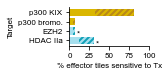

In [102]:
# fraction of tiles sensitive to inhibition
# 148/183
# 27/404
# 129/409

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_inhib_results(option):
    plt.figure(figsize=(2.3,1.1))
    matplotlib.rcParams['hatch.linewidth'] = 2
    targets = ['p300 KIX', 'p300 bromo.', 'EZH2', 'HDAC IIa']
    percents1 = [100*148/183, 100*18/245, 100*27/404, 100*129/409]
    percents2 = [100*(148-89)/183, 100*(18-7)/245, 100*(27-8)/404, 100*(129-82)/409]
    pal2 = ['#DAB600', '#DAB600','#A6DFEE', '#A6DFEE']
    hatchpal = ['#b98818', '#b98818', '#12a1b7', '#12a1b7']
    
    targets.reverse()
    percents1.reverse()
    percents2.reverse()
    pal2.reverse()
    hatchpal.reverse()
    
    for i, y1, y2, c, h in zip(range(len(targets)), percents1, percents2, pal2, hatchpal):
        if option == 0:
            plt.barh(i, y1, color=c, lw=0)
        elif (option == 1) | (option == 2):
            plt.barh(i, y1, color=c, hatch='////', edgecolor=h, lw=0)
            plt.barh(i, y2, color=c)
            if option == 2:
                if i < 2:
                    plt.annotate(xy=(y1+4, i-0.3), text='*', va='center', ha='center')

    plt.yticks(ticks=range(len(targets)), labels=targets)
    plt.ylabel('Target')
    plt.xlim(0,100)
    plt.xticks([0,25,50,75,100])
#     plt.xlabel('Percent of effector tiles\nsensitive to treatment (%)')
    plt.xlabel('% effector tiles sensitive to Tx')
    sns.despine()
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure 3/chemical_inhibition_fraction_senstivie_bar_%d.png' % option, dpi=600)
    
    
# plot_inhib_results(0)
# plot_inhib_results(1)
plot_inhib_results(2)

### Chemical validations

#### Prepare data

In [29]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/HHVhits_chem-inhib_Screen_validations_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['mCitrine-A']>1e7, True, False)
df.loc[df['Protein'].isna(), 'Protein'] = 'empty' 
df = df.replace(to_replace='taz', value='tazemetostat')

aggdf = df.groupby(by=['Reporter', 'Condition', 'Treatment', 'Construct', 'Protein', 'Replicate', 'Time'], as_index=False).mean()
aggdf = aggdf.replace(to_replace='taz', value='tazemetostat')

key = pd.read_csv('../Flow Single-Cell Data - CSV/HHV-chem-inhib_validations_key.csv')

print('Complete')

Complete


In [30]:
constructDict = {'CL144':['Human', 'MYBA', '', ''],
                 'JT151':['Human', 'KRAB', '', ''],
                 'JT126':['', 'empty', '', '']}

info = pd.read_csv('../Supplemental Tables - CSV/HHV-chemical-inhibition/HHVhits_added-info.csv')
infoA = info.drop(columns='Repression').rename(columns={'Activation':'Avg'})
infoA['Screen'] = 'Activation'
infoR = info.drop(columns='Activation').rename(columns={'Repression':'Avg'})
infoR['Screen'] = 'Repression'
info = pd.concat([infoA, infoR])

key = pd.read_csv('../Flow Single-Cell Data - CSV/HHV-chem-inhib_validations_key.csv')
key = key[['Construct', 'Tile_ID']].rename(columns={'Tile_ID':'Tile ID'})
key = pd.merge(key, info, on='Tile ID', how='left')

for i in constructDict:
    key.loc[key['Construct']==i, 'Virus Abbreviation'] = constructDict[i][0]
    key.loc[key['Construct']==i, 'Protein'] = constructDict[i][1]
    key.loc[key['Construct']==i, 'Tile Start'] = constructDict[i][2]
    key.loc[key['Construct']==i, 'Tile End'] = constructDict[i][3]

aggdfA = aggdf[aggdf['Reporter']=='DY032']
aggdfA = aggdfA[['Construct', 'Condition', 'Treatment', 'Replicate', 'Citrine_Act']]
aggdfA['Citrine OFF'] = 1 - aggdfA['Citrine_Act']  

normdf = aggdfA[aggdfA['Condition']=='dox']
normdf['Citrine ON'] = normdf['Citrine_Act']*100
normdf = normdf.groupby(by=['Construct', 'Treatment'])['Citrine ON'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine ON', 'std':'ON std'})
keyA = pd.merge(key[key['Screen']=='Activation'], normdf, on='Construct', how='left').drop_duplicates(subset=['Treatment', 'Tile ID', 'Screen'])

aggdfR = aggdf[aggdf['Reporter']=='JT039']
aggdfR = aggdfR[['Construct', 'Condition', 'Treatment', 'Replicate', 'Citrine_Rep']]
aggdfR['Citrine OFF'] = 1 - aggdfR['Citrine_Rep']

normdf = aggdfR[aggdfR['Condition']=='dox']
normdf['Citrine OFF'] = normdf['Citrine OFF']*100
normdf = normdf.groupby(by=['Construct', 'Treatment'])['Citrine OFF'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine OFF', 'std':'OFF std'})

keyR = pd.merge(key[key['Screen']=='Repression'], normdf, on='Construct', how='left').drop_duplicates(subset=['Treatment', 'Tile ID', 'Screen'])
print('Complete')

Complete


<ipython-input-30-289131fd7652>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine ON'] = normdf['Citrine_Act']*100
<ipython-input-30-289131fd7652>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine OFF'] = normdf['Citrine OFF']*100


#### All validation flow cytometry distributions (not featured in a figure panel)

In [325]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validations_subset(df, screentype, key, protein):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        yvar = 'Citrine ON'
        opposite = 'Repression'
        cutoff = 3e6
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        yvar = 'Citrine OFF'
        opposite = 'Activation'
        cutoff = 1e7
    
    df = df[(df['Reporter']==reporter) & (df['Protein']==protein)]
    df['mCitrine'] = np.log10(df['mCitrine-A'])
    df = df.drop(columns='Protein')
    df = pd.merge(df, key[['Construct', 'Treatment', 'Avg', 'Virus Abbreviation', 'Protein', 'Tile Start', 'Tile End', yvar, 'Screen']], how='left', on=['Construct', 'Treatment'])
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Condition'] = pd.Categorical(df['Condition'], categories=['nodox', 'dox'], ordered=True)
    df = df.sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    df['Condition-Replicate'] = df['Condition'].astype(str) + '-' + df['Replicate']
    
    labeldf = df[df['Screen']!=opposite].sort_values(by=['Avg'], ascending=False)
    labeldf = labeldf[['Construct', 'Virus Abbreviation', 'Protein', 'Treatment', 'Tile Start', 'Tile End', yvar, 'Avg']].drop_duplicates(subset=['Construct', 'Treatment'])
    labeldf['Tile Start'] = np.where(labeldf['Tile Start']=='', labeldf['Tile Start'], labeldf['Tile Start'].astype(str).str.split('.').str[0])
    labeldf['Tile End'] = np.where(labeldf['Tile End']=='', labeldf['Tile End'], labeldf['Tile End'].astype(str).str.split('.').str[0])
    labeldf['Sample'] = np.where(labeldf['Tile Start']=='', labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'],
                             labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'] + '\n[' \
                             + labeldf['Tile Start'] + '-' + labeldf['Tile End'] + ']\n' + labeldf['Treatment'])
    labeldf['Construct-Treatment'] = labeldf['Construct'] + '_' + labeldf['Treatment']

    df['Construct-Treatment'] = df['Construct'] + '_' + df['Treatment']
    samples = dict(zip(list(labeldf['Construct-Treatment']), list(labeldf['Sample'])))
    df['Sample'] = df['Construct-Treatment'].map(samples)
    txorder = list(set(list(df['Treatment'])))
    txorder.sort(reverse=True)
    txorder = ['DMSO'] + [t for t in txorder if t != 'DMSO']
    df['Treatment'] = pd.Categorical(df['Treatment'], categories=txorder, ordered=True)
    df = df.sort_values(by='Treatment')
    labeldf['Treatment'] = pd.Categorical(labeldf['Treatment'], categories=txorder, ordered=True)
    labeldf = labeldf.sort_values(by='Treatment')
    df = df[df['Screen']!=opposite].sort_values(by=['Construct', 'Condition', 'Replicate'])
    
    if screentype == 'Activation':
        ON = list(labeldf[yvar])
        ON = [round(on, 1) for on in ON]
        OFF = [str(round(100-on, 1)) + '%' for on in ON]
        ON = [str(on) + '%' for on in ON]
        
    elif screentype == 'Repression':
        OFF = list(labeldf[yvar])
        OFF = [round(off, 1) for off in OFF]
        ON = [str(round(100-off, 1)) + '%' for off in OFF]
        OFF = [str(off) + '%' for off in OFF]
        
    pal = sns.color_palette(['#999999', '#999999', color, color])
    if len(df) == 0:
        return None
    
    g = sns.FacetGrid(data=df, row='Sample',
                      hue='Condition-Replicate', palette=pal,
                      aspect=1, height=1.25)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=0.2)
    g.map(plt.axvline, x=np.log10(cutoff), ls=':', color='#333333', lw=1)
    g.set_titles(template='{row_name}')
    plt.xlim([4.5,9.5])
    plt.ylim([0,4])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for ax, on, off in zip(g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
        ax.grid(False)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure S4/chem-inhib_subsets/HHVhits_chem-inhib_%s_%s_subset_validations_kdeplot.png' % (screentype, '-'.join(protein.split(' '))), dpi=1200)
    plt.close()

keyA2 = keyA.copy()
keyA2['Protein'] = keyA2['Virus Abbreviation'] + ' ' + keyA2['Protein']
protA = set(keyA2['Protein'])
for a in protA:
    print(a)
    plot_validations_subset(df, 'Activation', keyA, a)

keyR2 = keyR.copy()
keyR2['Protein'] = keyR2['Virus Abbreviation'] + ' ' + keyR2['Protein']
protR = set(keyR2['Protein'])
for r in protR:
    print(r)
    plot_validations_subset(df, 'Repression', keyR, r)
print('Complete')

HHV7 U8
EBV RTA


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV EBNA4
HSV1 VP16


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV DBP


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HCMV RL5A
KSHV KbZIP
KSHV ORF10


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HCMV IE2
KSHV RTA


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV VIRF2


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HHV7 U84
HHV7 U8


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV RTA
EBV EBNA4


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HSV1 VP16
KSHV DBP
HCMV RL5A


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV KbZIP


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV ORF10
HCMV IE2


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV RTA
KSHV VIRF2


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HHV7 U84


<ipython-input-325-304524499c81>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


Complete


### END

### Archived - compiling max strength tiles

In [16]:
# get dataframe with screen hits, their scores in each screen, and other important information; drop duplicates
allTiles = pd.read_csv('Screen_Files/HHV/HHV_ActivD2-ReprD5_detailed.csv')
allTiles = allTiles[['Tile ID', 'Tile Start', 'Tile End', 'Virus Abbreviation', 'Protein', 'Tile Sequence', 'DNA Sequence', 'Avg', 'Hit', 'Screen']]

allTilesAct = allTiles[allTiles['Screen']=='Activation'].rename(columns={'Avg':'Activation'}).drop(columns=['Screen'])
allTilesRep = allTiles[allTiles['Screen']=='Repression'].rename(columns={'Avg':'Repression'}).drop(columns=['Screen'])
allTiles = pd.merge(allTilesAct, allTilesRep, on=['Tile ID', 'Tile Start', 'Tile End', 'Virus Abbreviation', 'Protein', 'Tile Sequence', 'DNA Sequence'], how='outer')

# as of now, keeping fiducial, immune, and random controls
hitTiles = allTiles[(allTiles['Hit_x']==1)|(allTiles['Hit_y']==1)].drop(columns=['Hit_x','Hit_y']).drop_duplicates(subset='DNA Sequence')
hitTiles['Control'] = np.where(hitTiles['Tile ID'].str.contains('random'), 'random control', 'HHV tile')
hitTiles['Control'] = np.where(hitTiles['Tile ID'].str.contains('fiducial'), 'fiducial control', hitTiles['Control'])
# sns.scatterplot(data=hitTiles, y='Activation', x='Repression', hue='Control', palette='Set1')
# print('Number of tiles in library:', len(hitTiles))
hitTiles.to_csv('Screen_Files/HHV/HHV_ActivD2-ReprD5_Hits.csv', index=False)
hitTiles

,Tile ID,Tile Start,Tile End,Virus Abbreviation,Protein,Tile Sequence,DNA Sequence,Activation,Repression,Control
0,F5HCV3_058,571.0,650.0,KSHV,RTA,SEAQPPLLSLPPPLDVDQSLFALLDEAGPETWDVGSPLSPTDDALL...,AGCGAGGCTCAGCCACCCCTTCTGTCTTTGCCCCCTCCTCTGGATG...,10.916126,1.344783,HHV tile
1,F5HCV3_057,561.0,640.0,KSHV,RTA,ATDVATSEGPSEAQPPLLSLPPPLDVDQSLFALLDEAGPETWDVGS...,GCGACAGACGTTGCCACTAGCGAGGGCCCAAGCGAAGCCCAACCCC...,10.870221,1.734280,HHV tile
2,F5HCV3_059,581.0,660.0,KSHV,RTA,PPPLDVDQSLFALLDEAGPETWDVGSPLSPTDDALLSSILQGLYQL...,CCACCCCCTCTGGATGTCGATCAGTCACTGTTCGCCCTCTTGGATG...,10.586600,0.868291,HHV tile
3,F5HCV3_056,551.0,630.0,KSHV,RTA,GSITTPQDVHATDVATSEGPSEAQPPLLSLPPPLDVDQSLFALLDE...,GGCTCTATTACAACTCCTCAGGACGTGCACGCAACCGATGTGGCTA...,10.529233,2.036393,HHV tile
4,Q2HR71_031,301.0,380.0,KSHV,VIRF2,SHVSGLDDCLPMVDHIEGCLLDLLSDVGQELPDLGDLGELLCETAS...,AGCCATGTGTCCGGACTTGATGACTGCCTCCCGATGGTAGACCACA...,10.396640,2.661039,HHV tile
...,...,...,...,...,...,...,...,...,...,...
40319,P52538_056,551.0,630.0,HHV6A,DBP,CKKNSLIDPVTGEDTFNVRSKKDFVSIIHGLTQCIEECVSRCIVEM...,TGCAAAAAGAACTCTCTGATCGATCCGGTCACAGGCGAGGACACAT...,NaN,0.781627,HHV tile
40320,P03188_007,61.0,140.0,EBV,gB,RFSSDIQCPSFGTRENHTEGLLMVFKDNIIPYSFKVRSYTKIVTNI...,AGGTTTAGCAGTGACATCCAGTGCCCTTCTTTCGGGACACGGGAAA...,NaN,0.764671,HHV tile
40321,P52538_013,121.0,200.0,HHV6B,DBP,EVPTARKVIDIKALCSAVGKDADSVICHVACGNGFKELLFAGLLIP...,GAGGTCCCTACTGCCAGGAAGGTGATCGACATTAAGGCGCTCTGCT...,NaN,0.756696,HHV tile
40322,P36320_030,291.0,370.0,HHV6A,gB,MLKHWTTVTHGLRAETDETYHFISKELTAAFVASKESLNLTDPKQT...,ATGCTTAAGCACTGGACAACTGTCACTCATGGCCTCAGGGCTGAGA...,NaN,0.741871,HHV tile


In [ ]:
# prepare perturbation library of strongest tiles within domains
# read in domain csv and use tile info above to identify strongest tile in each domain

def maxTile(tileDF, domainDF, screentype):
    uIDList = list(domainDF['UniProt ID'])
    startList = list(domainDF['Start'])
    endList = list(domainDF['End'])
    tempdfList = []
    for i in range(len(uIDList)):
        tempdf = tileDF[tileDF['Tile ID'].str.contains(uIDList[i])]
        tempdf = tempdf[(tempdf['Tile Start']>=startList[i]) & (tempdf['Tile End']<=endList[i])]
        maxscore = max(list(tempdf[screentype]))
        tempdf = tempdf[tempdf[screentype]==maxscore]
        tempdfList.append(tempdf)
    return pd.concat(tempdfList)

doms = pd.read_csv('../Manuscript_Figures/Screen_Files/HHV/HHV_domains.csv')
domsA = doms[doms['Effect']=='Activation']
domsR = doms[doms['Effect']=='Repression']

maxAct = maxTile(hitTiles, domAct, 'Activation')
maxRep = maxTile(hitTiles, domRep, 'Repression')

maxTiles = pd.concat([maxAct, maxRep]).drop_duplicates(subset='Tile ID').reset_index().drop(columns='index')
maxTiles

In [ ]:
maxTilesFiltered = maxTiles[(maxTiles['Activation']>=5.29) | (maxTiles['Repression']>=1.98)]
maxTilesFiltered.to_csv('HHV-perturb_max-tiles.csv', index=False)
maxTilesFiltered